# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'netifier-kmeans'
epochs = 10
batch_size = 32
sequence_length = 96

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/netifier-2/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier-2/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [7]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [9]:
train_labels = train_data.columns[2:6]
val_labels = val_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


# BUILD DATASET & DATALOADERS

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [11]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [12]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [13]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    ) 

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [14]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [15]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [16]:
def kmeans_clustering_sampling(model, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    model.eval()
    start_time = time.time()
    embeddings = []
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)
    
    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        target_samples = len(embeddings[:math.ceil(0.1 * len(embeddings))])
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
                
        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(embeddings)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 10)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances <= local_threshold]
                collected_indices.update(below_threshold_indices)

            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'pornografi': [y_train[i][0] for i in temp],
                    'sara': [y_train[i][1] for i in temp],
                    'radikalisme': [y_train[i][2] for i in temp],
                    'pencemaran_nama_baik': [y_train[i][3] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            # print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        threshold_data = pd.DataFrame({
            'Threshold': thresholds
        })
        threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

# MAIN LOOP

In [17]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i)
        notebook_launcher(kmeans_clustering_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [18]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5903, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4917, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4703, Accuracy: 0.8167, F1 Micro: 0.259, F1 Macro: 0.187
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.398, Accuracy: 0.8417, F1 Micro: 0.4813, F1 Macro: 0.414
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3739, Accuracy: 0.8522, F1 Micro: 0.5456, F1 Macro: 0.4863
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3021, Accuracy: 0.8609, F1 Micro: 0.6048, F1 Macro: 0.5756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2618, Accuracy: 0.867, F1 Micro: 0.678, F1 Macro: 0.6657
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2249, Accuracy: 0.8678, F1 Micro: 0.68, F1 Macro: 0.6722
Epoch 9/10, Train Loss: 0.1872, Accuracy: 0.8722, F1 Micro: 0.6715, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.529, Accuracy: 0.8178, F1 Micro: 0.2776, F1 Macro: 0.2052
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3858, Accuracy: 0.8414, F1 Micro: 0.4649, F1 Macro: 0.3576
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3035, Accuracy: 0.8687, F1 Micro: 0.6506, F1 Macro: 0.6373
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2393, Accuracy: 0.8706, F1 Micro: 0.707, F1 Macro: 0.6996
Epoch 5/10, Train Loss: 0.194, Accuracy: 0.8792, F1 Micro: 0.6948, F1 Macro: 0.684
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.155, Accuracy: 0.8792, F1 Micro: 0.7246, F1 Macro: 0.7187
Epoch 7/10, Train Loss: 0.1289, Accuracy: 0.8788, F1 Micro: 0.7158, F1 Macro: 0.7078
Epoch 8/10, Train Loss: 0.0967, Accuracy: 0.8828, F1 Micro: 0.7197, F1 Macro: 0.7083
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0803, Accuracy: 0.8764, F1 Micro: 0.729, F1 Macro: 0.7255
Epoch 10/10, Train Loss: 0.0624, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4894, Accuracy: 0.8339, F1 Micro: 0.3922, F1 Macro: 0.2732
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3309, Accuracy: 0.8662, F1 Micro: 0.686, F1 Macro: 0.6812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.244, Accuracy: 0.8798, F1 Micro: 0.7106, F1 Macro: 0.6994
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.202, Accuracy: 0.8884, F1 Micro: 0.7398, F1 Macro: 0.733
Epoch 5/10, Train Loss: 0.1612, Accuracy: 0.8877, F1 Micro: 0.7282, F1 Macro: 0.7158
Epoch 6/10, Train Loss: 0.1267, Accuracy: 0.8855, F1 Micro: 0.7379, F1 Macro: 0.7319
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.099, Accuracy: 0.8884, F1 Micro: 0.7411, F1 Macro: 0.7323
Epoch 8/10, Train Loss: 0.0751, Accuracy: 0.8906, F1 Micro: 0.74, F1 Macro: 0.7334
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0684, Accuracy: 0.89, F1 Micro: 0.7523, F1 Macro: 0.7468
Epoch 10/10, Train Loss: 0.0542, Accuracy: 0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.476, Accuracy: 0.8372, F1 Micro: 0.4428, F1 Macro: 0.3168
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.305, Accuracy: 0.8769, F1 Micro: 0.6828, F1 Macro: 0.6718
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2336, Accuracy: 0.8872, F1 Micro: 0.7265, F1 Macro: 0.715
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1897, Accuracy: 0.8866, F1 Micro: 0.7445, F1 Macro: 0.7387
Epoch 5/10, Train Loss: 0.1592, Accuracy: 0.8895, F1 Micro: 0.743, F1 Macro: 0.7385
Epoch 6/10, Train Loss: 0.1191, Accuracy: 0.89, F1 Micro: 0.7341, F1 Macro: 0.7219
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0939, Accuracy: 0.8883, F1 Micro: 0.7473, F1 Macro: 0.7424
Epoch 8/10, Train Loss: 0.0723, Accuracy: 0.8888, F1 Micro: 0.7441, F1 Macro: 0.7406
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.8909, F1 Micro: 0.748, F1 Macro: 0.7455
Epoch 10/10, Train Loss: 0.0497, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4476, Accuracy: 0.865, F1 Micro: 0.6382, F1 Macro: 0.6071
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2715, Accuracy: 0.8814, F1 Micro: 0.7008, F1 Macro: 0.6937
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2161, Accuracy: 0.8858, F1 Micro: 0.7179, F1 Macro: 0.714
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1719, Accuracy: 0.8877, F1 Micro: 0.7522, F1 Macro: 0.7474
Epoch 5/10, Train Loss: 0.146, Accuracy: 0.8931, F1 Micro: 0.7393, F1 Macro: 0.7278
Epoch 6/10, Train Loss: 0.1095, Accuracy: 0.8889, F1 Micro: 0.7483, F1 Macro: 0.7422
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.8858, F1 Micro: 0.7499, F1 Macro: 0.7446
Epoch 8/10, Train Loss: 0.0645, Accuracy: 0.8906, F1 Micro: 0.7482, F1 Macro: 0.7442
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.892, F1 Micro: 0.7473, F1 Macro: 0.7399
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.039, Accuracy: 0.8878, F1 Micro: 0.7546, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4386, Accuracy: 0.8667, F1 Micro: 0.629, F1 Macro: 0.6084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2798, Accuracy: 0.8841, F1 Micro: 0.7049, F1 Macro: 0.6973
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2269, Accuracy: 0.8852, F1 Micro: 0.7447, F1 Macro: 0.7396
Epoch 4/10, Train Loss: 0.1772, Accuracy: 0.8933, F1 Micro: 0.7337, F1 Macro: 0.7269
Epoch 5/10, Train Loss: 0.1403, Accuracy: 0.8934, F1 Micro: 0.7321, F1 Macro: 0.7218
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.101, Accuracy: 0.8933, F1 Micro: 0.7569, F1 Macro: 0.7539
Epoch 7/10, Train Loss: 0.0824, Accuracy: 0.8955, F1 Micro: 0.7518, F1 Macro: 0.7452
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.8945, F1 Micro: 0.7495, F1 Macro: 0.7446
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.8933, F1 Micro: 0.7654, F1 Macro: 0.7619
Epoch 10/10, Train Loss: 0.0431, Accuracy: 0.895, F1 Micro: 0.7602, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4277, Accuracy: 0.8684, F1 Micro: 0.6307, F1 Macro: 0.6149
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2724, Accuracy: 0.8863, F1 Micro: 0.7286, F1 Macro: 0.7243
Epoch 3/10, Train Loss: 0.2135, Accuracy: 0.89, F1 Micro: 0.6979, F1 Macro: 0.6852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1738, Accuracy: 0.8934, F1 Micro: 0.7594, F1 Macro: 0.7538
Epoch 5/10, Train Loss: 0.1398, Accuracy: 0.8945, F1 Micro: 0.755, F1 Macro: 0.7508
Epoch 6/10, Train Loss: 0.1081, Accuracy: 0.8934, F1 Micro: 0.7561, F1 Macro: 0.7531
Epoch 7/10, Train Loss: 0.0802, Accuracy: 0.8933, F1 Micro: 0.7526, F1 Macro: 0.7506
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.8947, F1 Micro: 0.7556, F1 Macro: 0.7514
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.8939, F1 Micro: 0.7586, F1 Macro: 0.7588
Epoch 10/10, Train Loss: 0.0376, Accuracy: 0.8919, F1 Micro: 0.7582, F1 Macro: 0.7553

 Iteration 3122: Accuracy: 0.8934, F1 Micro: 0.7594,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4296, Accuracy: 0.8761, F1 Micro: 0.6884, F1 Macro: 0.6841
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2696, Accuracy: 0.8806, F1 Micro: 0.7419, F1 Macro: 0.7416
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2074, Accuracy: 0.8928, F1 Micro: 0.7523, F1 Macro: 0.7491
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1702, Accuracy: 0.8961, F1 Micro: 0.7598, F1 Macro: 0.7522
Epoch 5/10, Train Loss: 0.1361, Accuracy: 0.8945, F1 Micro: 0.7448, F1 Macro: 0.7359
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1091, Accuracy: 0.8956, F1 Micro: 0.7623, F1 Macro: 0.7583
Epoch 7/10, Train Loss: 0.0734, Accuracy: 0.893, F1 Micro: 0.7512, F1 Macro: 0.7414
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.8958, F1 Micro: 0.7591, F1 Macro: 0.7545
Epoch 9/10, Train Loss: 0.0465, Accuracy: 0.8953, F1 Micro: 0.7546, F1 Macro: 0.7523
Epoch 10/10, Train Loss: 0.0366, Accuracy: 0.8936, F1 Micro: 0.7606, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4163, Accuracy: 0.8716, F1 Micro: 0.6893, F1 Macro: 0.6869
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2578, Accuracy: 0.8934, F1 Micro: 0.7478, F1 Macro: 0.7399
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2098, Accuracy: 0.8925, F1 Micro: 0.7665, F1 Macro: 0.766
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.179, Accuracy: 0.8977, F1 Micro: 0.767, F1 Macro: 0.7588
Epoch 5/10, Train Loss: 0.1389, Accuracy: 0.8923, F1 Micro: 0.7603, F1 Macro: 0.7558
Epoch 6/10, Train Loss: 0.0992, Accuracy: 0.8964, F1 Micro: 0.7663, F1 Macro: 0.7647
Epoch 7/10, Train Loss: 0.0828, Accuracy: 0.8948, F1 Micro: 0.7463, F1 Macro: 0.7389
Epoch 8/10, Train Loss: 0.0613, Accuracy: 0.8966, F1 Micro: 0.7615, F1 Macro: 0.7565
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.8966, F1 Micro: 0.7552, F1 Macro: 0.7482
Epoch 10/10, Train Loss: 0.0373, Accuracy: 0.8938, F1 Micro: 0.743, F1 Macro: 0.7364

 Iteration 3711: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4172, Accuracy: 0.8742, F1 Micro: 0.7006, F1 Macro: 0.6946
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2647, Accuracy: 0.8909, F1 Micro: 0.7514, F1 Macro: 0.7486
Epoch 3/10, Train Loss: 0.2027, Accuracy: 0.8945, F1 Micro: 0.7352, F1 Macro: 0.7169
Epoch 4/10, Train Loss: 0.1624, Accuracy: 0.8948, F1 Micro: 0.7318, F1 Macro: 0.719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1345, Accuracy: 0.8952, F1 Micro: 0.7521, F1 Macro: 0.7399
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1036, Accuracy: 0.8967, F1 Micro: 0.7637, F1 Macro: 0.7582
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.8945, F1 Micro: 0.7571, F1 Macro: 0.7481
Epoch 8/10, Train Loss: 0.0565, Accuracy: 0.8922, F1 Micro: 0.7487, F1 Macro: 0.7439
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0472, Accuracy: 0.8966, F1 Micro: 0.7639, F1 Macro: 0.761
Epoch 10/10, Train Loss: 0.0362, Accuracy: 0.8913, F1 Micro: 0.7541, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4014, Accuracy: 0.8763, F1 Micro: 0.7023, F1 Macro: 0.6989
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2562, Accuracy: 0.8934, F1 Micro: 0.7434, F1 Macro: 0.7368
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2119, Accuracy: 0.8958, F1 Micro: 0.7561, F1 Macro: 0.7517
Epoch 4/10, Train Loss: 0.1716, Accuracy: 0.897, F1 Micro: 0.7491, F1 Macro: 0.7375
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1273, Accuracy: 0.8984, F1 Micro: 0.7626, F1 Macro: 0.7543
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1021, Accuracy: 0.8961, F1 Micro: 0.7692, F1 Macro: 0.7673
Epoch 7/10, Train Loss: 0.0736, Accuracy: 0.8953, F1 Micro: 0.7678, F1 Macro: 0.7626
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.8964, F1 Micro: 0.7689, F1 Macro: 0.7677
Epoch 9/10, Train Loss: 0.0437, Accuracy: 0.8988, F1 Micro: 0.765, F1 Macro: 0.7579
Epoch 10/10, Train Loss: 0.0339, Accuracy: 0.8981, F1 Micro: 0.7663, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3869, Accuracy: 0.8766, F1 Micro: 0.7146, F1 Macro: 0.7034
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2482, Accuracy: 0.8958, F1 Micro: 0.7412, F1 Macro: 0.7403
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2171, Accuracy: 0.8984, F1 Micro: 0.7594, F1 Macro: 0.7453
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1679, Accuracy: 0.9013, F1 Micro: 0.7642, F1 Macro: 0.757
Epoch 5/10, Train Loss: 0.1271, Accuracy: 0.8983, F1 Micro: 0.7442, F1 Macro: 0.7347
Epoch 6/10, Train Loss: 0.1018, Accuracy: 0.8978, F1 Micro: 0.7597, F1 Macro: 0.7533
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.8975, F1 Micro: 0.7532, F1 Macro: 0.7497
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.8992, F1 Micro: 0.7701, F1 Macro: 0.7655
Epoch 9/10, Train Loss: 0.0448, Accuracy: 0.8981, F1 Micro: 0.7513, F1 Macro: 0.7457
Epoch 10/10, Train Loss: 0.0388, Accuracy: 0.8947, F1 Micro: 0.7453, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4038, Accuracy: 0.8816, F1 Micro: 0.71, F1 Macro: 0.7047
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2604, Accuracy: 0.8934, F1 Micro: 0.7289, F1 Macro: 0.706
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2071, Accuracy: 0.8983, F1 Micro: 0.771, F1 Macro: 0.7662
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.8978, F1 Micro: 0.7694, F1 Macro: 0.7609
Epoch 5/10, Train Loss: 0.1287, Accuracy: 0.9011, F1 Micro: 0.7479, F1 Macro: 0.7416
Epoch 6/10, Train Loss: 0.0974, Accuracy: 0.898, F1 Micro: 0.771, F1 Macro: 0.7684
Epoch 7/10, Train Loss: 0.0729, Accuracy: 0.8989, F1 Micro: 0.7613, F1 Macro: 0.7565
Epoch 8/10, Train Loss: 0.0532, Accuracy: 0.8997, F1 Micro: 0.7697, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0421, Accuracy: 0.8988, F1 Micro: 0.7728, F1 Macro: 0.7716
Epoch 10/10, Train Loss: 0.0359, Accuracy: 0.9014, F1 Micro: 0.772, F1 Macro: 0.7671

 Iteration 4530: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3923, Accuracy: 0.8817, F1 Micro: 0.7136, F1 Macro: 0.7001
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.249, Accuracy: 0.8934, F1 Micro: 0.7325, F1 Macro: 0.7287
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2114, Accuracy: 0.9025, F1 Micro: 0.7647, F1 Macro: 0.7569
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1614, Accuracy: 0.897, F1 Micro: 0.7744, F1 Macro: 0.7725
Epoch 5/10, Train Loss: 0.1281, Accuracy: 0.8958, F1 Micro: 0.7674, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.9013, F1 Micro: 0.7773, F1 Macro: 0.7795
Epoch 7/10, Train Loss: 0.0712, Accuracy: 0.8953, F1 Micro: 0.7721, F1 Macro: 0.7724
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.9025, F1 Micro: 0.7687, F1 Macro: 0.7637
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.8953, F1 Micro: 0.7715, F1 Macro: 0.7722
Epoch 10/10, Train Loss: 0.0382, Accuracy: 0.8989, F1 Micro: 0.7753, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.395, Accuracy: 0.8789, F1 Micro: 0.672, F1 Macro: 0.6592
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2579, Accuracy: 0.8988, F1 Micro: 0.7521, F1 Macro: 0.7438
Epoch 3/10, Train Loss: 0.2001, Accuracy: 0.9006, F1 Micro: 0.744, F1 Macro: 0.7332
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1583, Accuracy: 0.9033, F1 Micro: 0.7758, F1 Macro: 0.7728
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1305, Accuracy: 0.9, F1 Micro: 0.7764, F1 Macro: 0.7705
Epoch 6/10, Train Loss: 0.0987, Accuracy: 0.903, F1 Micro: 0.7696, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0739, Accuracy: 0.9041, F1 Micro: 0.7769, F1 Macro: 0.7734
Epoch 8/10, Train Loss: 0.0533, Accuracy: 0.8981, F1 Micro: 0.7663, F1 Macro: 0.7654
Epoch 9/10, Train Loss: 0.0378, Accuracy: 0.8947, F1 Micro: 0.7579, F1 Macro: 0.755
Epoch 10/10, Train Loss: 0.0327, Accuracy: 0.8992, F1 Micro: 0.7682, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3864, Accuracy: 0.883, F1 Micro: 0.7322, F1 Macro: 0.7275
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2461, Accuracy: 0.8992, F1 Micro: 0.7712, F1 Macro: 0.7695
Epoch 3/10, Train Loss: 0.2038, Accuracy: 0.8973, F1 Micro: 0.7663, F1 Macro: 0.7594
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1605, Accuracy: 0.9005, F1 Micro: 0.7748, F1 Macro: 0.7685
Epoch 5/10, Train Loss: 0.1216, Accuracy: 0.9019, F1 Micro: 0.7671, F1 Macro: 0.7608
Epoch 6/10, Train Loss: 0.0937, Accuracy: 0.9017, F1 Micro: 0.757, F1 Macro: 0.751
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9016, F1 Micro: 0.7623, F1 Macro: 0.7525
Epoch 8/10, Train Loss: 0.0549, Accuracy: 0.898, F1 Micro: 0.7708, F1 Macro: 0.7691
Epoch 9/10, Train Loss: 0.0419, Accuracy: 0.9017, F1 Micro: 0.7657, F1 Macro: 0.7628
Epoch 10/10, Train Loss: 0.0362, Accuracy: 0.8939, F1 Micro: 0.7688, F1 Macro: 0.7702

 Iteration 5063: Accuracy: 0.9005, F1 Micro: 0.7748, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3812, Accuracy: 0.8866, F1 Micro: 0.7252, F1 Macro: 0.7203
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2489, Accuracy: 0.8969, F1 Micro: 0.7679, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1966, Accuracy: 0.9033, F1 Micro: 0.77, F1 Macro: 0.7617
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.8992, F1 Micro: 0.7612, F1 Macro: 0.7558
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1206, Accuracy: 0.9025, F1 Micro: 0.7767, F1 Macro: 0.7742
Epoch 6/10, Train Loss: 0.094, Accuracy: 0.9, F1 Micro: 0.7589, F1 Macro: 0.7569
Epoch 7/10, Train Loss: 0.0668, Accuracy: 0.8992, F1 Micro: 0.7652, F1 Macro: 0.7577
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0497, Accuracy: 0.9033, F1 Micro: 0.7801, F1 Macro: 0.776
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.9031, F1 Micro: 0.7771, F1 Macro: 0.7747
Epoch 10/10, Train Loss: 0.0344, Accuracy: 0.8936, F1 Micro: 0.7732, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3796, Accuracy: 0.8875, F1 Micro: 0.7101, F1 Macro: 0.6938
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.256, Accuracy: 0.8973, F1 Micro: 0.7593, F1 Macro: 0.7484
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2027, Accuracy: 0.9044, F1 Micro: 0.7827, F1 Macro: 0.7763
Epoch 4/10, Train Loss: 0.1576, Accuracy: 0.9031, F1 Micro: 0.7726, F1 Macro: 0.7612
Epoch 5/10, Train Loss: 0.1233, Accuracy: 0.9055, F1 Micro: 0.7743, F1 Macro: 0.7689
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.9011, F1 Micro: 0.7769, F1 Macro: 0.7729
Epoch 7/10, Train Loss: 0.0662, Accuracy: 0.9014, F1 Micro: 0.7738, F1 Macro: 0.7711
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.9056, F1 Micro: 0.7796, F1 Macro: 0.7762
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.8998, F1 Micro: 0.7819, F1 Macro: 0.7844
Epoch 10/10, Train Loss: 0.0346, Accuracy: 0.9033, F1 Micro: 0.7774, F1 Macro: 0.7728

 Iteration 5441: Accuracy: 0.9044, F1 Micro: 0.782

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3812, Accuracy: 0.8848, F1 Micro: 0.7063, F1 Macro: 0.7031
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2441, Accuracy: 0.902, F1 Micro: 0.7565, F1 Macro: 0.7511
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2024, Accuracy: 0.9042, F1 Micro: 0.7654, F1 Macro: 0.7541
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1535, Accuracy: 0.908, F1 Micro: 0.7805, F1 Macro: 0.7744
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.9055, F1 Micro: 0.7879, F1 Macro: 0.7865
Epoch 6/10, Train Loss: 0.0925, Accuracy: 0.907, F1 Micro: 0.78, F1 Macro: 0.7721
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.9031, F1 Micro: 0.7693, F1 Macro: 0.7667
Epoch 8/10, Train Loss: 0.0533, Accuracy: 0.8992, F1 Micro: 0.7784, F1 Macro: 0.7771
Epoch 9/10, Train Loss: 0.0377, Accuracy: 0.902, F1 Micro: 0.7787, F1 Macro: 0.7771
Epoch 10/10, Train Loss: 0.0332, Accuracy: 0.9033, F1 Micro: 0.7758, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3832, Accuracy: 0.8844, F1 Micro: 0.7004, F1 Macro: 0.678
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2444, Accuracy: 0.8972, F1 Micro: 0.7559, F1 Macro: 0.7534
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2036, Accuracy: 0.9075, F1 Micro: 0.774, F1 Macro: 0.7683
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.16, Accuracy: 0.9078, F1 Micro: 0.7831, F1 Macro: 0.7783
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.9048, F1 Micro: 0.7718, F1 Macro: 0.7651
Epoch 6/10, Train Loss: 0.0867, Accuracy: 0.9058, F1 Micro: 0.7786, F1 Macro: 0.7742
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.9016, F1 Micro: 0.7549, F1 Macro: 0.7535
Epoch 8/10, Train Loss: 0.0514, Accuracy: 0.9039, F1 Micro: 0.776, F1 Macro: 0.771
Epoch 9/10, Train Loss: 0.0403, Accuracy: 0.905, F1 Micro: 0.7758, F1 Macro: 0.7716
Epoch 10/10, Train Loss: 0.0344, Accuracy: 0.9008, F1 Micro: 0.7703, F1 Macro: 0.7646

 Iteration 5841: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3715, Accuracy: 0.8867, F1 Micro: 0.7314, F1 Macro: 0.7296
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2348, Accuracy: 0.9003, F1 Micro: 0.7603, F1 Macro: 0.7486
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1974, Accuracy: 0.9, F1 Micro: 0.7761, F1 Macro: 0.7726
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.16, Accuracy: 0.9041, F1 Micro: 0.7798, F1 Macro: 0.7756
Epoch 5/10, Train Loss: 0.1185, Accuracy: 0.9072, F1 Micro: 0.7767, F1 Macro: 0.7718
Epoch 6/10, Train Loss: 0.0876, Accuracy: 0.9034, F1 Micro: 0.7753, F1 Macro: 0.7688
Epoch 7/10, Train Loss: 0.0623, Accuracy: 0.9055, F1 Micro: 0.7738, F1 Macro: 0.7719
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.9033, F1 Micro: 0.7765, F1 Macro: 0.7715
Epoch 9/10, Train Loss: 0.0385, Accuracy: 0.9048, F1 Micro: 0.7742, F1 Macro: 0.7708
Epoch 10/10, Train Loss: 0.0309, Accuracy: 0.9061, F1 Micro: 0.77, F1 Macro: 0.7655

 Iteration 6041: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3555, Accuracy: 0.8852, F1 Micro: 0.7101, F1 Macro: 0.691
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2387, Accuracy: 0.9005, F1 Micro: 0.7718, F1 Macro: 0.7663
Epoch 3/10, Train Loss: 0.1912, Accuracy: 0.9056, F1 Micro: 0.7672, F1 Macro: 0.7582
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1541, Accuracy: 0.9095, F1 Micro: 0.7924, F1 Macro: 0.7883
Epoch 5/10, Train Loss: 0.114, Accuracy: 0.9081, F1 Micro: 0.7906, F1 Macro: 0.7893
Epoch 6/10, Train Loss: 0.0892, Accuracy: 0.8994, F1 Micro: 0.7846, F1 Macro: 0.7871
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.8994, F1 Micro: 0.7804, F1 Macro: 0.7798
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9075, F1 Micro: 0.7798, F1 Macro: 0.7761
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9062, F1 Micro: 0.7758, F1 Macro: 0.772
Epoch 10/10, Train Loss: 0.0278, Accuracy: 0.9014, F1 Micro: 0.7729, F1 Macro: 0.769

 Iteration 6218: Accuracy: 0.9095, F1 Micro: 0.7924, 

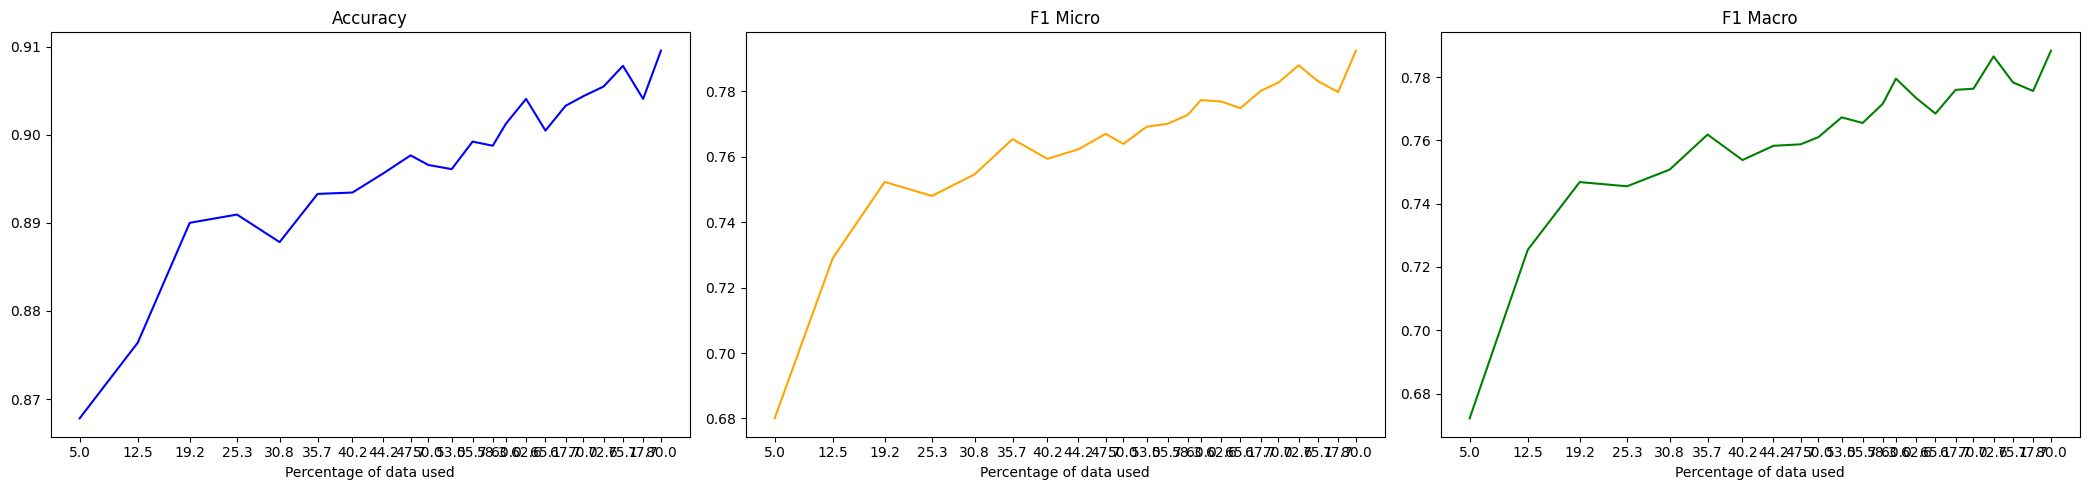

In [19]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5968, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4973, Accuracy: 0.7958, F1 Micro: 0.0815, F1 Macro: 0.0678
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4357, Accuracy: 0.8263, F1 Micro: 0.3178, F1 Macro: 0.2216
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4166, Accuracy: 0.8441, F1 Micro: 0.4791, F1 Macro: 0.4013
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3434, Accuracy: 0.848, F1 Micro: 0.5003, F1 Macro: 0.4164
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3181, Accuracy: 0.8561, F1 Micro: 0.569, F1 Macro: 0.4892
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.28, Accuracy: 0.8608, F1 Micro: 0.6101, F1 Macro: 0.56
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2362, Accuracy: 0.8725, F1 Micro: 0.6686, F1 Macro: 0.6486
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1874, Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5231, Accuracy: 0.8214, F1 Micro: 0.2843, F1 Macro: 0.2038
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.386, Accuracy: 0.8416, F1 Micro: 0.4708, F1 Macro: 0.3839
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3072, Accuracy: 0.8612, F1 Micro: 0.5993, F1 Macro: 0.5548
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2299, Accuracy: 0.8772, F1 Micro: 0.6722, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2124, Accuracy: 0.8814, F1 Micro: 0.7196, F1 Macro: 0.7173
Epoch 6/10, Train Loss: 0.1592, Accuracy: 0.8817, F1 Micro: 0.6916, F1 Macro: 0.6748
Epoch 7/10, Train Loss: 0.1316, Accuracy: 0.8847, F1 Micro: 0.7179, F1 Macro: 0.7061
Epoch 8/10, Train Loss: 0.1083, Accuracy: 0.8845, F1 Micro: 0.7114, F1 Macro: 0.7053
Epoch 9/10, Train Loss: 0.0914, Accuracy: 0.8827, F1 Micro: 0.7044, F1 Macro: 0.6925
Epoch 10/10, Train Loss: 0.0698, Accuracy: 0.8836, F1 Micro: 0.7173, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4977, Accuracy: 0.8375, F1 Micro: 0.4515, F1 Macro: 0.3596
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3313, Accuracy: 0.8764, F1 Micro: 0.6832, F1 Macro: 0.6697
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2533, Accuracy: 0.8827, F1 Micro: 0.7292, F1 Macro: 0.7261
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2082, Accuracy: 0.8875, F1 Micro: 0.7353, F1 Macro: 0.7315
Epoch 5/10, Train Loss: 0.1647, Accuracy: 0.8894, F1 Micro: 0.732, F1 Macro: 0.7263
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.14, Accuracy: 0.8856, F1 Micro: 0.7448, F1 Macro: 0.7396
Epoch 7/10, Train Loss: 0.1081, Accuracy: 0.89, F1 Micro: 0.7305, F1 Macro: 0.7247
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0829, Accuracy: 0.8892, F1 Micro: 0.7494, F1 Macro: 0.7414
Epoch 9/10, Train Loss: 0.0705, Accuracy: 0.8928, F1 Micro: 0.7407, F1 Macro: 0.7322
Epoch 10/10, Train Loss: 0.058, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4693, Accuracy: 0.8531, F1 Micro: 0.6243, F1 Macro: 0.5523
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3158, Accuracy: 0.8805, F1 Micro: 0.7112, F1 Macro: 0.708
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2434, Accuracy: 0.8892, F1 Micro: 0.7456, F1 Macro: 0.7445
Epoch 4/10, Train Loss: 0.2013, Accuracy: 0.8928, F1 Micro: 0.74, F1 Macro: 0.7338
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1588, Accuracy: 0.8944, F1 Micro: 0.7524, F1 Macro: 0.7474
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1293, Accuracy: 0.8856, F1 Micro: 0.7537, F1 Macro: 0.7542
Epoch 7/10, Train Loss: 0.0996, Accuracy: 0.8917, F1 Micro: 0.7462, F1 Macro: 0.7379
Epoch 8/10, Train Loss: 0.0803, Accuracy: 0.8883, F1 Micro: 0.7464, F1 Macro: 0.7427
Epoch 9/10, Train Loss: 0.06, Accuracy: 0.8923, F1 Micro: 0.7445, F1 Macro: 0.7404
Epoch 10/10, Train Loss: 0.0487, Accuracy: 0.8931, F1 Micro: 0.7436, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4453, Accuracy: 0.8633, F1 Micro: 0.6039, F1 Macro: 0.5467
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.284, Accuracy: 0.8869, F1 Micro: 0.7342, F1 Macro: 0.7249
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2216, Accuracy: 0.8938, F1 Micro: 0.7483, F1 Macro: 0.7453
Epoch 4/10, Train Loss: 0.1871, Accuracy: 0.8923, F1 Micro: 0.7424, F1 Macro: 0.7403
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.895, F1 Micro: 0.7348, F1 Macro: 0.7221
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1186, Accuracy: 0.8914, F1 Micro: 0.7593, F1 Macro: 0.7579
Epoch 7/10, Train Loss: 0.0864, Accuracy: 0.8908, F1 Micro: 0.757, F1 Macro: 0.7534
Epoch 8/10, Train Loss: 0.0749, Accuracy: 0.8969, F1 Micro: 0.7444, F1 Macro: 0.7363
Epoch 9/10, Train Loss: 0.0542, Accuracy: 0.8875, F1 Micro: 0.7576, F1 Macro: 0.7579
Epoch 10/10, Train Loss: 0.0451, Accuracy: 0.8884, F1 Micro: 0.7546, F1 Macro: 0.7539

 Iteration 2394: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4388, Accuracy: 0.8675, F1 Micro: 0.6261, F1 Macro: 0.6014
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2722, Accuracy: 0.8841, F1 Micro: 0.7135, F1 Macro: 0.7026
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2155, Accuracy: 0.8948, F1 Micro: 0.7571, F1 Macro: 0.755
Epoch 4/10, Train Loss: 0.1801, Accuracy: 0.8992, F1 Micro: 0.7462, F1 Macro: 0.7428
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1318, Accuracy: 0.8939, F1 Micro: 0.7679, F1 Macro: 0.7648
Epoch 6/10, Train Loss: 0.1094, Accuracy: 0.8972, F1 Micro: 0.7621, F1 Macro: 0.7509
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.8922, F1 Micro: 0.7596, F1 Macro: 0.7582
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.8989, F1 Micro: 0.7636, F1 Macro: 0.7594
Epoch 9/10, Train Loss: 0.0445, Accuracy: 0.8945, F1 Micro: 0.7667, F1 Macro: 0.7638
Epoch 10/10, Train Loss: 0.0395, Accuracy: 0.8984, F1 Micro: 0.7605, F1 Macro: 0.7562

 Iteration 2777: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4226, Accuracy: 0.8687, F1 Micro: 0.7111, F1 Macro: 0.7073
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2623, Accuracy: 0.8863, F1 Micro: 0.7517, F1 Macro: 0.7498
Epoch 3/10, Train Loss: 0.202, Accuracy: 0.8964, F1 Micro: 0.7385, F1 Macro: 0.7315
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1749, Accuracy: 0.8969, F1 Micro: 0.7638, F1 Macro: 0.7607
Epoch 5/10, Train Loss: 0.1404, Accuracy: 0.8977, F1 Micro: 0.7559, F1 Macro: 0.7515
Epoch 6/10, Train Loss: 0.1004, Accuracy: 0.8898, F1 Micro: 0.7624, F1 Macro: 0.7579
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0784, Accuracy: 0.9008, F1 Micro: 0.7646, F1 Macro: 0.7574
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.8934, F1 Micro: 0.7585, F1 Macro: 0.7518
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0552, Accuracy: 0.8964, F1 Micro: 0.7711, F1 Macro: 0.7716
Epoch 10/10, Train Loss: 0.0367, Accuracy: 0.8975, F1 Micro: 0.7682, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4173, Accuracy: 0.8797, F1 Micro: 0.6944, F1 Macro: 0.6761
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2564, Accuracy: 0.8939, F1 Micro: 0.7492, F1 Macro: 0.7485
Epoch 3/10, Train Loss: 0.2036, Accuracy: 0.8988, F1 Micro: 0.7404, F1 Macro: 0.7319
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1659, Accuracy: 0.8995, F1 Micro: 0.755, F1 Macro: 0.7442
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1328, Accuracy: 0.8989, F1 Micro: 0.77, F1 Macro: 0.7664
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.9005, F1 Micro: 0.7747, F1 Macro: 0.7736
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.8997, F1 Micro: 0.7691, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.9005, F1 Micro: 0.7795, F1 Macro: 0.7796
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.8984, F1 Micro: 0.767, F1 Macro: 0.7642
Epoch 10/10, Train Loss: 0.0355, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4036, Accuracy: 0.8813, F1 Micro: 0.6931, F1 Macro: 0.6871
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2632, Accuracy: 0.8889, F1 Micro: 0.7578, F1 Macro: 0.7576
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2077, Accuracy: 0.8989, F1 Micro: 0.7679, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1652, Accuracy: 0.9047, F1 Micro: 0.7741, F1 Macro: 0.7707
Epoch 5/10, Train Loss: 0.1288, Accuracy: 0.9, F1 Micro: 0.7664, F1 Macro: 0.7614
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.9002, F1 Micro: 0.7629, F1 Macro: 0.7523
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0756, Accuracy: 0.9005, F1 Micro: 0.775, F1 Macro: 0.772
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.9, F1 Micro: 0.7726, F1 Macro: 0.7679
Epoch 9/10, Train Loss: 0.0473, Accuracy: 0.8973, F1 Micro: 0.7727, F1 Macro: 0.7725
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0347, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4013, Accuracy: 0.8808, F1 Micro: 0.7062, F1 Macro: 0.7031
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.247, Accuracy: 0.8947, F1 Micro: 0.7533, F1 Macro: 0.7423
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1931, Accuracy: 0.897, F1 Micro: 0.7647, F1 Macro: 0.7589
Epoch 4/10, Train Loss: 0.1664, Accuracy: 0.8973, F1 Micro: 0.7317, F1 Macro: 0.7178
Epoch 5/10, Train Loss: 0.1233, Accuracy: 0.9005, F1 Micro: 0.759, F1 Macro: 0.7496
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.898, F1 Micro: 0.7512, F1 Macro: 0.7437
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0667, Accuracy: 0.8989, F1 Micro: 0.7688, F1 Macro: 0.7665
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.8967, F1 Micro: 0.7632, F1 Macro: 0.7621
Epoch 9/10, Train Loss: 0.0436, Accuracy: 0.8942, F1 Micro: 0.7657, F1 Macro: 0.7688
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0373, Accuracy: 0.9011, F1 Micro: 0.7801, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.388, Accuracy: 0.8806, F1 Micro: 0.7193, F1 Macro: 0.7112
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2568, Accuracy: 0.8925, F1 Micro: 0.7266, F1 Macro: 0.7054
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2001, Accuracy: 0.8934, F1 Micro: 0.7401, F1 Macro: 0.7322
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1543, Accuracy: 0.9003, F1 Micro: 0.7692, F1 Macro: 0.7611
Epoch 5/10, Train Loss: 0.1178, Accuracy: 0.898, F1 Micro: 0.7573, F1 Macro: 0.7535
Epoch 6/10, Train Loss: 0.0908, Accuracy: 0.8989, F1 Micro: 0.7606, F1 Macro: 0.7499
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0631, Accuracy: 0.9025, F1 Micro: 0.7724, F1 Macro: 0.7727
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.9011, F1 Micro: 0.7778, F1 Macro: 0.7775
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.8995, F1 Micro: 0.7649, F1 Macro: 0.7618
Epoch 10/10, Train Loss: 0.0343, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3995, Accuracy: 0.8828, F1 Micro: 0.731, F1 Macro: 0.7238
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2456, Accuracy: 0.8989, F1 Micro: 0.7594, F1 Macro: 0.757
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1991, Accuracy: 0.8969, F1 Micro: 0.7738, F1 Macro: 0.7729
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.8992, F1 Micro: 0.7679, F1 Macro: 0.759
Epoch 5/10, Train Loss: 0.1263, Accuracy: 0.8989, F1 Micro: 0.7687, F1 Macro: 0.7639
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0902, Accuracy: 0.8994, F1 Micro: 0.7744, F1 Macro: 0.7721
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.9011, F1 Micro: 0.7623, F1 Macro: 0.7581
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.897, F1 Micro: 0.7764, F1 Macro: 0.778
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0447, Accuracy: 0.9, F1 Micro: 0.7767, F1 Macro: 0.777
Epoch 10/10, Train Loss: 0.0368, Accuracy: 0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3939, Accuracy: 0.8814, F1 Micro: 0.7169, F1 Macro: 0.7016
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2515, Accuracy: 0.8995, F1 Micro: 0.7584, F1 Macro: 0.7502
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2037, Accuracy: 0.9031, F1 Micro: 0.7692, F1 Macro: 0.7654
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.8977, F1 Micro: 0.7641, F1 Macro: 0.7581
Epoch 5/10, Train Loss: 0.1244, Accuracy: 0.9016, F1 Micro: 0.7506, F1 Macro: 0.7346
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.9005, F1 Micro: 0.7673, F1 Macro: 0.7646
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0695, Accuracy: 0.9031, F1 Micro: 0.771, F1 Macro: 0.7681
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.9014, F1 Micro: 0.7715, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.041, Accuracy: 0.8997, F1 Micro: 0.7754, F1 Macro: 0.7744
Epoch 10/10, Train Loss: 0.0301, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3871, Accuracy: 0.8841, F1 Micro: 0.7137, F1 Macro: 0.7092
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2442, Accuracy: 0.8981, F1 Micro: 0.7502, F1 Macro: 0.7299
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2014, Accuracy: 0.9016, F1 Micro: 0.7642, F1 Macro: 0.7571
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1607, Accuracy: 0.9028, F1 Micro: 0.7715, F1 Macro: 0.7668
Epoch 5/10, Train Loss: 0.1195, Accuracy: 0.9041, F1 Micro: 0.7709, F1 Macro: 0.7624
Epoch 6/10, Train Loss: 0.0918, Accuracy: 0.9003, F1 Micro: 0.7682, F1 Macro: 0.7593
Epoch 7/10, Train Loss: 0.0658, Accuracy: 0.8997, F1 Micro: 0.7631, F1 Macro: 0.756
Epoch 8/10, Train Loss: 0.0538, Accuracy: 0.9025, F1 Micro: 0.7587, F1 Macro: 0.7483
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.9023, F1 Micro: 0.7765, F1 Macro: 0.7747
Epoch 10/10, Train Loss: 0.0322, Accuracy: 0.8963, F1 Micro: 0.7693, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3844, Accuracy: 0.8825, F1 Micro: 0.7358, F1 Macro: 0.7355
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2394, Accuracy: 0.8959, F1 Micro: 0.7483, F1 Macro: 0.7409
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2009, Accuracy: 0.9027, F1 Micro: 0.7785, F1 Macro: 0.7726
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1519, Accuracy: 0.902, F1 Micro: 0.7802, F1 Macro: 0.7799
Epoch 5/10, Train Loss: 0.1247, Accuracy: 0.9034, F1 Micro: 0.7767, F1 Macro: 0.7742
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9027, F1 Micro: 0.7755, F1 Macro: 0.7755
Epoch 7/10, Train Loss: 0.0706, Accuracy: 0.9014, F1 Micro: 0.7698, F1 Macro: 0.7646
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.8958, F1 Micro: 0.7747, F1 Macro: 0.7761
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.041, Accuracy: 0.9045, F1 Micro: 0.7811, F1 Macro: 0.779
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.9003, F1 Micro: 0.7785, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3806, Accuracy: 0.8834, F1 Micro: 0.6907, F1 Macro: 0.6583
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2412, Accuracy: 0.8959, F1 Micro: 0.762, F1 Macro: 0.7597
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2004, Accuracy: 0.9003, F1 Micro: 0.7639, F1 Macro: 0.7625
Epoch 4/10, Train Loss: 0.1564, Accuracy: 0.8997, F1 Micro: 0.7617, F1 Macro: 0.7581
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.898, F1 Micro: 0.7786, F1 Macro: 0.7813
Epoch 6/10, Train Loss: 0.0867, Accuracy: 0.9016, F1 Micro: 0.7689, F1 Macro: 0.7618
Epoch 7/10, Train Loss: 0.0682, Accuracy: 0.9034, F1 Micro: 0.7696, F1 Macro: 0.7638
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.8986, F1 Micro: 0.7685, F1 Macro: 0.7672
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.8991, F1 Micro: 0.7699, F1 Macro: 0.7669
Epoch 10/10, Train Loss: 0.0321, Accuracy: 0.8992, F1 Micro: 0.7758, F1 Macro: 0.7757

 Iteration 5063: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3758, Accuracy: 0.89, F1 Micro: 0.7421, F1 Macro: 0.7388
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2507, Accuracy: 0.8992, F1 Micro: 0.7686, F1 Macro: 0.7646
Epoch 3/10, Train Loss: 0.1923, Accuracy: 0.9002, F1 Micro: 0.7579, F1 Macro: 0.7476
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1509, Accuracy: 0.9041, F1 Micro: 0.7769, F1 Macro: 0.7743
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.9022, F1 Micro: 0.7614, F1 Macro: 0.7504
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.099, Accuracy: 0.9006, F1 Micro: 0.7787, F1 Macro: 0.7795
Epoch 7/10, Train Loss: 0.0667, Accuracy: 0.8969, F1 Micro: 0.7758, F1 Macro: 0.778
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.9013, F1 Micro: 0.7744, F1 Macro: 0.7719
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.9025, F1 Micro: 0.7687, F1 Macro: 0.7625
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0338, Accuracy: 0.9, F1 Micro: 0.7789, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3694, Accuracy: 0.8945, F1 Micro: 0.7475, F1 Macro: 0.7405
Epoch 2/10, Train Loss: 0.2314, Accuracy: 0.8984, F1 Micro: 0.7463, F1 Macro: 0.7391
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1897, Accuracy: 0.9025, F1 Micro: 0.7611, F1 Macro: 0.7562
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1564, Accuracy: 0.902, F1 Micro: 0.7628, F1 Macro: 0.7551
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1241, Accuracy: 0.9017, F1 Micro: 0.7682, F1 Macro: 0.7672
Epoch 6/10, Train Loss: 0.086, Accuracy: 0.903, F1 Micro: 0.7647, F1 Macro: 0.7543
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0644, Accuracy: 0.9039, F1 Micro: 0.7785, F1 Macro: 0.7783
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9072, F1 Micro: 0.784, F1 Macro: 0.7818
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.9008, F1 Micro: 0.7682, F1 Macro: 0.7655
Epoch 10/10, Train Loss: 0.0314, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3753, Accuracy: 0.8905, F1 Micro: 0.7219, F1 Macro: 0.7064
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2471, Accuracy: 0.8988, F1 Micro: 0.7616, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1986, Accuracy: 0.9016, F1 Micro: 0.7771, F1 Macro: 0.7715
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.16, Accuracy: 0.9052, F1 Micro: 0.7808, F1 Macro: 0.7706
Epoch 5/10, Train Loss: 0.1239, Accuracy: 0.9045, F1 Micro: 0.7781, F1 Macro: 0.775
Epoch 6/10, Train Loss: 0.0863, Accuracy: 0.9034, F1 Micro: 0.7678, F1 Macro: 0.7656
Epoch 7/10, Train Loss: 0.063, Accuracy: 0.9017, F1 Micro: 0.7675, F1 Macro: 0.7613
Epoch 8/10, Train Loss: 0.0471, Accuracy: 0.9025, F1 Micro: 0.7804, F1 Macro: 0.7795
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0367, Accuracy: 0.9022, F1 Micro: 0.7844, F1 Macro: 0.7866
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.9038, F1 Micro: 0.7717, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3788, Accuracy: 0.8883, F1 Micro: 0.7042, F1 Macro: 0.6868
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2388, Accuracy: 0.9022, F1 Micro: 0.7747, F1 Macro: 0.7712
Epoch 3/10, Train Loss: 0.2, Accuracy: 0.9066, F1 Micro: 0.7723, F1 Macro: 0.765
Epoch 4/10, Train Loss: 0.1599, Accuracy: 0.9039, F1 Micro: 0.7621, F1 Macro: 0.7496
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1172, Accuracy: 0.9042, F1 Micro: 0.7801, F1 Macro: 0.7735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0875, Accuracy: 0.9008, F1 Micro: 0.7848, F1 Macro: 0.7849
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.9038, F1 Micro: 0.7695, F1 Macro: 0.7611
Epoch 8/10, Train Loss: 0.047, Accuracy: 0.9044, F1 Micro: 0.7698, F1 Macro: 0.7648
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9023, F1 Micro: 0.7778, F1 Macro: 0.775
Epoch 10/10, Train Loss: 0.0315, Accuracy: 0.9041, F1 Micro: 0.7804, F1 Macro: 0.7776

 Iteration 5841: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3692, Accuracy: 0.8903, F1 Micro: 0.7464, F1 Macro: 0.7392
Epoch 2/10, Train Loss: 0.235, Accuracy: 0.8963, F1 Micro: 0.727, F1 Macro: 0.7151
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1963, Accuracy: 0.9017, F1 Micro: 0.7842, F1 Macro: 0.7776
Epoch 4/10, Train Loss: 0.1573, Accuracy: 0.9073, F1 Micro: 0.7824, F1 Macro: 0.7757
Epoch 5/10, Train Loss: 0.1206, Accuracy: 0.9041, F1 Micro: 0.7764, F1 Macro: 0.7712
Epoch 6/10, Train Loss: 0.0885, Accuracy: 0.9036, F1 Micro: 0.7799, F1 Macro: 0.7751
Epoch 7/10, Train Loss: 0.0639, Accuracy: 0.9044, F1 Micro: 0.7732, F1 Macro: 0.7691
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.9002, F1 Micro: 0.7768, F1 Macro: 0.7734
Epoch 9/10, Train Loss: 0.0441, Accuracy: 0.9039, F1 Micro: 0.7782, F1 Macro: 0.7764
Epoch 10/10, Train Loss: 0.029, Accuracy: 0.9055, F1 Micro: 0.7785, F1 Macro: 0.7747

 Iteration 6041: Accuracy: 0.9017, F1 Micro: 0.7842, F1 Macro: 0.7776
               

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3553, Accuracy: 0.8931, F1 Micro: 0.7351, F1 Macro: 0.7295
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2344, Accuracy: 0.9013, F1 Micro: 0.771, F1 Macro: 0.7598
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1948, Accuracy: 0.9066, F1 Micro: 0.78, F1 Macro: 0.7746
Epoch 4/10, Train Loss: 0.1483, Accuracy: 0.9061, F1 Micro: 0.7648, F1 Macro: 0.7554
Epoch 5/10, Train Loss: 0.1152, Accuracy: 0.9034, F1 Micro: 0.7663, F1 Macro: 0.7539
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0808, Accuracy: 0.9055, F1 Micro: 0.7828, F1 Macro: 0.7787
Epoch 7/10, Train Loss: 0.0647, Accuracy: 0.903, F1 Micro: 0.7781, F1 Macro: 0.777
Epoch 8/10, Train Loss: 0.0465, Accuracy: 0.9053, F1 Micro: 0.7801, F1 Macro: 0.7748
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.9036, F1 Micro: 0.7731, F1 Macro: 0.7693
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.9033, F1 Micro: 0.7763, F1 Macro: 0.7713

 Iteration 6218: Accu

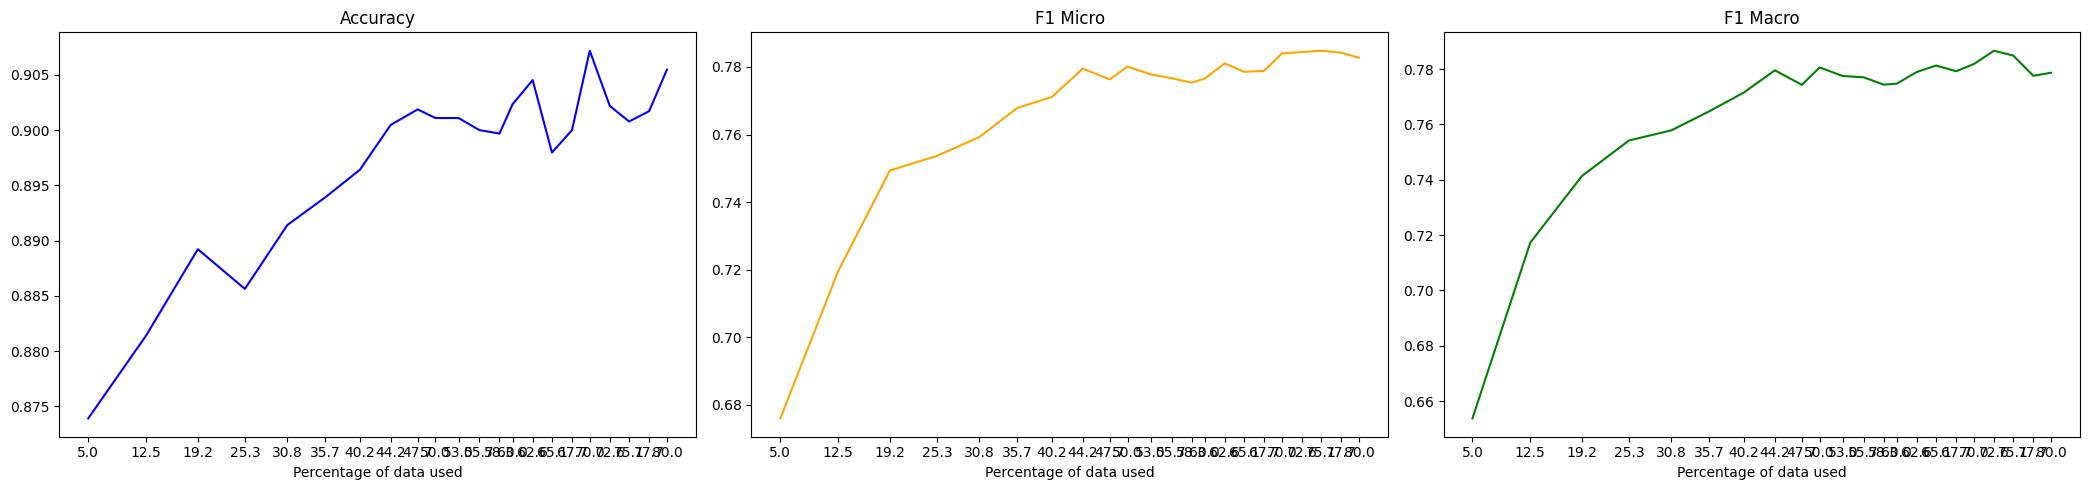

In [20]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.573, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4299, Accuracy: 0.793, F1 Micro: 0.0569, F1 Macro: 0.0488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.398, Accuracy: 0.8236, F1 Micro: 0.2957, F1 Macro: 0.2101
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3572, Accuracy: 0.8389, F1 Micro: 0.4256, F1 Macro: 0.3377
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2998, Accuracy: 0.8417, F1 Micro: 0.4468, F1 Macro: 0.3645
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2759, Accuracy: 0.8531, F1 Micro: 0.5406, F1 Macro: 0.4609
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2245, Accuracy: 0.8637, F1 Micro: 0.6152, F1 Macro: 0.5822
Epoch 8/10, Train Loss: 0.1944, Accuracy: 0.8647, F1 Micro: 0.5957, F1 Macro: 0.5446
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1747, Accuracy: 0.8687, F1 Micro: 0.643

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5146, Accuracy: 0.8177, F1 Micro: 0.2581, F1 Macro: 0.1895
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3585, Accuracy: 0.8475, F1 Micro: 0.501, F1 Macro: 0.4299
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2937, Accuracy: 0.8644, F1 Micro: 0.6007, F1 Macro: 0.5811
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2135, Accuracy: 0.8781, F1 Micro: 0.7194, F1 Macro: 0.7146
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1784, Accuracy: 0.8867, F1 Micro: 0.72, F1 Macro: 0.709
Epoch 6/10, Train Loss: 0.1457, Accuracy: 0.8817, F1 Micro: 0.7134, F1 Macro: 0.7123
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1097, Accuracy: 0.8836, F1 Micro: 0.7282, F1 Macro: 0.7246
Epoch 8/10, Train Loss: 0.0807, Accuracy: 0.8886, F1 Micro: 0.7255, F1 Macro: 0.7205
Epoch 9/10, Train Loss: 0.0638, Accuracy: 0.8873, F1 Micro: 0.7255, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4851, Accuracy: 0.8277, F1 Micro: 0.3391, F1 Macro: 0.2437
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3224, Accuracy: 0.8712, F1 Micro: 0.693, F1 Macro: 0.6767
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2466, Accuracy: 0.8805, F1 Micro: 0.7153, F1 Macro: 0.7142
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1981, Accuracy: 0.89, F1 Micro: 0.7299, F1 Macro: 0.7202
Epoch 5/10, Train Loss: 0.1663, Accuracy: 0.8834, F1 Micro: 0.6787, F1 Macro: 0.658
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1288, Accuracy: 0.8898, F1 Micro: 0.7448, F1 Macro: 0.7405
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1037, Accuracy: 0.8897, F1 Micro: 0.748, F1 Macro: 0.745
Epoch 8/10, Train Loss: 0.0789, Accuracy: 0.8902, F1 Micro: 0.7332, F1 Macro: 0.7243
Epoch 9/10, Train Loss: 0.0649, Accuracy: 0.8922, F1 Micro: 0.7344, F1 Macro: 0.7231
Epoch 10/10, Train Loss: 0.0532, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4656, Accuracy: 0.8486, F1 Micro: 0.5133, F1 Macro: 0.4342
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2913, Accuracy: 0.8775, F1 Micro: 0.6957, F1 Macro: 0.6855
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2242, Accuracy: 0.8859, F1 Micro: 0.7226, F1 Macro: 0.7027
Epoch 4/10, Train Loss: 0.1884, Accuracy: 0.8856, F1 Micro: 0.6973, F1 Macro: 0.6631
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1639, Accuracy: 0.8897, F1 Micro: 0.7486, F1 Macro: 0.7394
Epoch 6/10, Train Loss: 0.1222, Accuracy: 0.8909, F1 Micro: 0.7299, F1 Macro: 0.7191
Epoch 7/10, Train Loss: 0.0886, Accuracy: 0.8902, F1 Micro: 0.7448, F1 Macro: 0.7391
Epoch 8/10, Train Loss: 0.0742, Accuracy: 0.8906, F1 Micro: 0.7342, F1 Macro: 0.7232
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.8881, F1 Micro: 0.7328, F1 Macro: 0.7142
Epoch 10/10, Train Loss: 0.051, Accuracy: 0.8906, F1 Micro: 0.731, F1 Macro: 0.7215

 Iteration 1969: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4451, Accuracy: 0.863, F1 Micro: 0.6145, F1 Macro: 0.5831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2795, Accuracy: 0.88, F1 Micro: 0.7355, F1 Macro: 0.7357
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2116, Accuracy: 0.8864, F1 Micro: 0.7515, F1 Macro: 0.7488
Epoch 4/10, Train Loss: 0.1723, Accuracy: 0.8902, F1 Micro: 0.7405, F1 Macro: 0.7354
Epoch 5/10, Train Loss: 0.1364, Accuracy: 0.8884, F1 Micro: 0.7277, F1 Macro: 0.7048
Epoch 6/10, Train Loss: 0.1009, Accuracy: 0.8925, F1 Micro: 0.7454, F1 Macro: 0.7426
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.8903, F1 Micro: 0.7292, F1 Macro: 0.709
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.8952, F1 Micro: 0.7594, F1 Macro: 0.7547
Epoch 9/10, Train Loss: 0.0523, Accuracy: 0.8908, F1 Micro: 0.7395, F1 Macro: 0.7268
Epoch 10/10, Train Loss: 0.04, Accuracy: 0.8952, F1 Micro: 0.7501, F1 Macro: 0.7496

 Iteration 2394: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4363, Accuracy: 0.8723, F1 Micro: 0.6495, F1 Macro: 0.6306
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2571, Accuracy: 0.8859, F1 Micro: 0.7157, F1 Macro: 0.6993
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.219, Accuracy: 0.8938, F1 Micro: 0.743, F1 Macro: 0.7349
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1733, Accuracy: 0.8936, F1 Micro: 0.7525, F1 Macro: 0.7433
Epoch 5/10, Train Loss: 0.1384, Accuracy: 0.8936, F1 Micro: 0.7433, F1 Macro: 0.7321
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1018, Accuracy: 0.8931, F1 Micro: 0.7532, F1 Macro: 0.748
Epoch 7/10, Train Loss: 0.0751, Accuracy: 0.8928, F1 Micro: 0.7495, F1 Macro: 0.7383
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.8931, F1 Micro: 0.7487, F1 Macro: 0.7409
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.8892, F1 Micro: 0.7617, F1 Macro: 0.7604
Epoch 10/10, Train Loss: 0.0383, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4176, Accuracy: 0.8761, F1 Micro: 0.6809, F1 Macro: 0.6727
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2648, Accuracy: 0.8934, F1 Micro: 0.7446, F1 Macro: 0.7263
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1969, Accuracy: 0.8966, F1 Micro: 0.7535, F1 Macro: 0.7491
Epoch 4/10, Train Loss: 0.1683, Accuracy: 0.8898, F1 Micro: 0.752, F1 Macro: 0.7471
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.8948, F1 Micro: 0.7505, F1 Macro: 0.7426
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.893, F1 Micro: 0.758, F1 Macro: 0.7519
Epoch 7/10, Train Loss: 0.078, Accuracy: 0.8956, F1 Micro: 0.7551, F1 Macro: 0.7495
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.8938, F1 Micro: 0.7554, F1 Macro: 0.7488
Epoch 9/10, Train Loss: 0.051, Accuracy: 0.8939, F1 Micro: 0.7495, F1 Macro: 0.7425
Epoch 10/10, Train Loss: 0.0381, Accuracy: 0.8922, F1 Micro: 0.7491, F1 Macro: 0.7451

 Iteration 3122: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4171, Accuracy: 0.8758, F1 Micro: 0.6777, F1 Macro: 0.6704
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2651, Accuracy: 0.8925, F1 Micro: 0.7342, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2046, Accuracy: 0.8917, F1 Micro: 0.7634, F1 Macro: 0.7601
Epoch 4/10, Train Loss: 0.1723, Accuracy: 0.8931, F1 Micro: 0.7511, F1 Macro: 0.7391
Epoch 5/10, Train Loss: 0.1267, Accuracy: 0.8977, F1 Micro: 0.7444, F1 Macro: 0.7317
Epoch 6/10, Train Loss: 0.0977, Accuracy: 0.8947, F1 Micro: 0.7537, F1 Macro: 0.7475
Epoch 7/10, Train Loss: 0.0695, Accuracy: 0.8966, F1 Micro: 0.7615, F1 Macro: 0.7575
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.8959, F1 Micro: 0.7616, F1 Macro: 0.7578
Epoch 9/10, Train Loss: 0.0411, Accuracy: 0.8936, F1 Micro: 0.7633, F1 Macro: 0.7596
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0393, Accuracy: 0.8955, F1 Micro: 0.7644, F1 Macro: 0.759

 Iteration 3432: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4023, Accuracy: 0.8777, F1 Micro: 0.7064, F1 Macro: 0.7
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2478, Accuracy: 0.8945, F1 Micro: 0.7516, F1 Macro: 0.7464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2086, Accuracy: 0.8972, F1 Micro: 0.7581, F1 Macro: 0.7508
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1568, Accuracy: 0.8975, F1 Micro: 0.7669, F1 Macro: 0.7618
Epoch 5/10, Train Loss: 0.1326, Accuracy: 0.8931, F1 Micro: 0.7496, F1 Macro: 0.7406
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.895, F1 Micro: 0.7558, F1 Macro: 0.753
Epoch 7/10, Train Loss: 0.0808, Accuracy: 0.8952, F1 Micro: 0.7514, F1 Macro: 0.7451
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0531, Accuracy: 0.8956, F1 Micro: 0.7693, F1 Macro: 0.7673
Epoch 9/10, Train Loss: 0.0461, Accuracy: 0.8902, F1 Micro: 0.7619, F1 Macro: 0.7596
Epoch 10/10, Train Loss: 0.0337, Accuracy: 0.8947, F1 Micro: 0.7589, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4027, Accuracy: 0.8767, F1 Micro: 0.7028, F1 Macro: 0.6958
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2495, Accuracy: 0.8928, F1 Micro: 0.7467, F1 Macro: 0.7365
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2071, Accuracy: 0.8955, F1 Micro: 0.766, F1 Macro: 0.7594
Epoch 4/10, Train Loss: 0.1703, Accuracy: 0.898, F1 Micro: 0.7638, F1 Macro: 0.7562
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.8991, F1 Micro: 0.7523, F1 Macro: 0.738
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.8919, F1 Micro: 0.7582, F1 Macro: 0.7539
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.8964, F1 Micro: 0.7595, F1 Macro: 0.7536
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.8959, F1 Micro: 0.7645, F1 Macro: 0.7632
Epoch 9/10, Train Loss: 0.048, Accuracy: 0.895, F1 Micro: 0.7574, F1 Macro: 0.7525
Epoch 10/10, Train Loss: 0.0369, Accuracy: 0.8948, F1 Micro: 0.7654, F1 Macro: 0.7633

 Iteration 3886: Accuracy: 0.8955, F1 Micro: 0.766, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3897, Accuracy: 0.8792, F1 Micro: 0.72, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2541, Accuracy: 0.8955, F1 Micro: 0.7521, F1 Macro: 0.7352
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2111, Accuracy: 0.8973, F1 Micro: 0.7591, F1 Macro: 0.7494
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.8908, F1 Micro: 0.7633, F1 Macro: 0.7606
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1338, Accuracy: 0.8928, F1 Micro: 0.7667, F1 Macro: 0.7646
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0921, Accuracy: 0.8945, F1 Micro: 0.7686, F1 Macro: 0.7679
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.8923, F1 Micro: 0.7566, F1 Macro: 0.7508
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.8966, F1 Micro: 0.755, F1 Macro: 0.7467
Epoch 9/10, Train Loss: 0.0434, Accuracy: 0.8983, F1 Micro: 0.7677, F1 Macro: 0.7668
Epoch 10/10, Train Loss: 0.0365, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3862, Accuracy: 0.8706, F1 Micro: 0.732, F1 Macro: 0.7363
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2468, Accuracy: 0.8948, F1 Micro: 0.7469, F1 Macro: 0.7353
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2034, Accuracy: 0.9005, F1 Micro: 0.7734, F1 Macro: 0.7676
Epoch 4/10, Train Loss: 0.1603, Accuracy: 0.8959, F1 Micro: 0.7689, F1 Macro: 0.7675
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.8942, F1 Micro: 0.755, F1 Macro: 0.7491
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.8963, F1 Micro: 0.7639, F1 Macro: 0.7584
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.8961, F1 Micro: 0.7629, F1 Macro: 0.761
Epoch 8/10, Train Loss: 0.0549, Accuracy: 0.8992, F1 Micro: 0.76, F1 Macro: 0.7526
Epoch 9/10, Train Loss: 0.045, Accuracy: 0.8955, F1 Micro: 0.7653, F1 Macro: 0.763
Epoch 10/10, Train Loss: 0.034, Accuracy: 0.8983, F1 Micro: 0.7586, F1 Macro: 0.7507

 Iteration 4330: Accuracy: 0.9005, F1 Micro: 0.7734, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3797, Accuracy: 0.8809, F1 Micro: 0.7035, F1 Macro: 0.7063
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.238, Accuracy: 0.8977, F1 Micro: 0.7651, F1 Macro: 0.7597
Epoch 3/10, Train Loss: 0.2064, Accuracy: 0.8958, F1 Micro: 0.7516, F1 Macro: 0.7484
Epoch 4/10, Train Loss: 0.1606, Accuracy: 0.9016, F1 Micro: 0.7635, F1 Macro: 0.7544
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1205, Accuracy: 0.9013, F1 Micro: 0.7666, F1 Macro: 0.759
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.8998, F1 Micro: 0.772, F1 Macro: 0.7683
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.8998, F1 Micro: 0.7543, F1 Macro: 0.743
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.8969, F1 Micro: 0.7622, F1 Macro: 0.7566
Epoch 9/10, Train Loss: 0.0411, Accuracy: 0.9013, F1 Micro: 0.7676, F1 Macro: 0.7649
Epoch 10/10, Train Loss: 0.0316, Accuracy: 0.9016, F1 Micro: 0.7711, F1 Macro: 0.7721

 Iteration 4530: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3736, Accuracy: 0.8845, F1 Micro: 0.7316, F1 Macro: 0.723
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2516, Accuracy: 0.89, F1 Micro: 0.7549, F1 Macro: 0.7501
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2031, Accuracy: 0.8984, F1 Micro: 0.7724, F1 Macro: 0.7656
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.9028, F1 Micro: 0.7701, F1 Macro: 0.7637
Epoch 5/10, Train Loss: 0.1274, Accuracy: 0.8978, F1 Micro: 0.754, F1 Macro: 0.7389
Epoch 6/10, Train Loss: 0.099, Accuracy: 0.9025, F1 Micro: 0.7559, F1 Macro: 0.7468
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9041, F1 Micro: 0.77, F1 Macro: 0.7608
Epoch 8/10, Train Loss: 0.0543, Accuracy: 0.8997, F1 Micro: 0.7622, F1 Macro: 0.7586
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9027, F1 Micro: 0.7697, F1 Macro: 0.7642
Epoch 10/10, Train Loss: 0.035, Accuracy: 0.9023, F1 Micro: 0.7612, F1 Macro: 0.7534

 Iteration 4663: Accuracy: 0.8984, F1 Micro: 0.7724, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3888, Accuracy: 0.8853, F1 Micro: 0.7245, F1 Macro: 0.7173
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2422, Accuracy: 0.8925, F1 Micro: 0.765, F1 Macro: 0.7615
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1954, Accuracy: 0.8975, F1 Micro: 0.776, F1 Macro: 0.7732
Epoch 4/10, Train Loss: 0.1677, Accuracy: 0.8998, F1 Micro: 0.7672, F1 Macro: 0.7585
Epoch 5/10, Train Loss: 0.1261, Accuracy: 0.9022, F1 Micro: 0.762, F1 Macro: 0.7568
Epoch 6/10, Train Loss: 0.0942, Accuracy: 0.9017, F1 Micro: 0.7654, F1 Macro: 0.7576
Epoch 7/10, Train Loss: 0.0719, Accuracy: 0.8984, F1 Micro: 0.7714, F1 Macro: 0.7704
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.8942, F1 Micro: 0.7717, F1 Macro: 0.7722
Epoch 9/10, Train Loss: 0.0421, Accuracy: 0.8986, F1 Micro: 0.7678, F1 Macro: 0.7657
Epoch 10/10, Train Loss: 0.0338, Accuracy: 0.9027, F1 Micro: 0.7742, F1 Macro: 0.7684

 Iteration 4863: Accuracy: 0.8975, F1 Micro: 0.776, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3759, Accuracy: 0.8863, F1 Micro: 0.7333, F1 Macro: 0.728
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2387, Accuracy: 0.8977, F1 Micro: 0.7373, F1 Macro: 0.7264
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1989, Accuracy: 0.8998, F1 Micro: 0.7728, F1 Macro: 0.7702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1681, Accuracy: 0.9041, F1 Micro: 0.7798, F1 Macro: 0.778
Epoch 5/10, Train Loss: 0.121, Accuracy: 0.9016, F1 Micro: 0.7687, F1 Macro: 0.7601
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.902, F1 Micro: 0.7617, F1 Macro: 0.7538
Epoch 7/10, Train Loss: 0.0685, Accuracy: 0.9033, F1 Micro: 0.7765, F1 Macro: 0.7729
Epoch 8/10, Train Loss: 0.0474, Accuracy: 0.9017, F1 Micro: 0.7769, F1 Macro: 0.7731
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.9008, F1 Micro: 0.7752, F1 Macro: 0.7735
Epoch 10/10, Train Loss: 0.0336, Accuracy: 0.8975, F1 Micro: 0.7685, F1 Macro: 0.7658

 Iteration 5063: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3769, Accuracy: 0.8886, F1 Micro: 0.7517, F1 Macro: 0.7474
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2351, Accuracy: 0.8966, F1 Micro: 0.7573, F1 Macro: 0.7426
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1965, Accuracy: 0.9009, F1 Micro: 0.7667, F1 Macro: 0.7654
Epoch 4/10, Train Loss: 0.1561, Accuracy: 0.8991, F1 Micro: 0.754, F1 Macro: 0.7462
Epoch 5/10, Train Loss: 0.1151, Accuracy: 0.902, F1 Micro: 0.7574, F1 Macro: 0.7534
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0915, Accuracy: 0.9033, F1 Micro: 0.7713, F1 Macro: 0.7677
Epoch 7/10, Train Loss: 0.0665, Accuracy: 0.9034, F1 Micro: 0.7682, F1 Macro: 0.761
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0483, Accuracy: 0.9016, F1 Micro: 0.7753, F1 Macro: 0.7723
Epoch 9/10, Train Loss: 0.037, Accuracy: 0.9028, F1 Micro: 0.7679, F1 Macro: 0.763
Epoch 10/10, Train Loss: 0.0286, Accuracy: 0.8995, F1 Micro: 0.7695, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3786, Accuracy: 0.8823, F1 Micro: 0.6866, F1 Macro: 0.6718
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2393, Accuracy: 0.8997, F1 Micro: 0.7577, F1 Macro: 0.7559
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1944, Accuracy: 0.9025, F1 Micro: 0.7784, F1 Macro: 0.7756
Epoch 4/10, Train Loss: 0.1552, Accuracy: 0.9033, F1 Micro: 0.7696, F1 Macro: 0.7639
Epoch 5/10, Train Loss: 0.1172, Accuracy: 0.8986, F1 Micro: 0.772, F1 Macro: 0.7699
Epoch 6/10, Train Loss: 0.0896, Accuracy: 0.9011, F1 Micro: 0.7697, F1 Macro: 0.7633
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.8991, F1 Micro: 0.7748, F1 Macro: 0.7727
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.9006, F1 Micro: 0.7701, F1 Macro: 0.7657
Epoch 9/10, Train Loss: 0.038, Accuracy: 0.8964, F1 Micro: 0.7707, F1 Macro: 0.769
Epoch 10/10, Train Loss: 0.0311, Accuracy: 0.9008, F1 Micro: 0.7682, F1 Macro: 0.7626

 Iteration 5441: Accuracy: 0.9025, F1 Micro: 0.7784,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3644, Accuracy: 0.8898, F1 Micro: 0.7506, F1 Macro: 0.7477
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2407, Accuracy: 0.9016, F1 Micro: 0.7668, F1 Macro: 0.7643
Epoch 3/10, Train Loss: 0.1945, Accuracy: 0.9022, F1 Micro: 0.764, F1 Macro: 0.7442
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1566, Accuracy: 0.9023, F1 Micro: 0.7811, F1 Macro: 0.7771
Epoch 5/10, Train Loss: 0.1141, Accuracy: 0.8978, F1 Micro: 0.7739, F1 Macro: 0.7727
Epoch 6/10, Train Loss: 0.0891, Accuracy: 0.9041, F1 Micro: 0.7567, F1 Macro: 0.7398
Epoch 7/10, Train Loss: 0.0647, Accuracy: 0.9008, F1 Micro: 0.7688, F1 Macro: 0.7639
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.8986, F1 Micro: 0.7717, F1 Macro: 0.7658
Epoch 9/10, Train Loss: 0.0411, Accuracy: 0.9014, F1 Micro: 0.7781, F1 Macro: 0.7747
Epoch 10/10, Train Loss: 0.0301, Accuracy: 0.8995, F1 Micro: 0.7765, F1 Macro: 0.7752

 Iteration 5641: Accuracy: 0.9023, F1 Micro: 0.781

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3659, Accuracy: 0.8863, F1 Micro: 0.705, F1 Macro: 0.6806
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2345, Accuracy: 0.9002, F1 Micro: 0.7624, F1 Macro: 0.7542
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2031, Accuracy: 0.9061, F1 Micro: 0.7825, F1 Macro: 0.7787
Epoch 4/10, Train Loss: 0.163, Accuracy: 0.8984, F1 Micro: 0.7789, F1 Macro: 0.7744
Epoch 5/10, Train Loss: 0.1211, Accuracy: 0.9, F1 Micro: 0.7673, F1 Macro: 0.7626
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.8992, F1 Micro: 0.7774, F1 Macro: 0.7757
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0662, Accuracy: 0.905, F1 Micro: 0.7835, F1 Macro: 0.7788
Epoch 8/10, Train Loss: 0.0487, Accuracy: 0.9042, F1 Micro: 0.7762, F1 Macro: 0.7703
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0345, Accuracy: 0.9047, F1 Micro: 0.786, F1 Macro: 0.7846
Epoch 10/10, Train Loss: 0.0334, Accuracy: 0.9052, F1 Micro: 0.7746, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3573, Accuracy: 0.8911, F1 Micro: 0.747, F1 Macro: 0.7384
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2403, Accuracy: 0.8994, F1 Micro: 0.7629, F1 Macro: 0.7589
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2031, Accuracy: 0.9069, F1 Micro: 0.7784, F1 Macro: 0.7752
Epoch 4/10, Train Loss: 0.1616, Accuracy: 0.9033, F1 Micro: 0.7598, F1 Macro: 0.7526
Epoch 5/10, Train Loss: 0.1205, Accuracy: 0.905, F1 Micro: 0.7745, F1 Macro: 0.7713
Epoch 6/10, Train Loss: 0.0832, Accuracy: 0.9033, F1 Micro: 0.7761, F1 Macro: 0.775
Epoch 7/10, Train Loss: 0.0591, Accuracy: 0.9013, F1 Micro: 0.7759, F1 Macro: 0.7772
Epoch 8/10, Train Loss: 0.0471, Accuracy: 0.9042, F1 Micro: 0.7696, F1 Macro: 0.7588
Epoch 9/10, Train Loss: 0.0367, Accuracy: 0.8994, F1 Micro: 0.7745, F1 Macro: 0.7725
Epoch 10/10, Train Loss: 0.0287, Accuracy: 0.9044, F1 Micro: 0.7689, F1 Macro: 0.7623

 Iteration 6041: Accuracy: 0.9069, F1 Micro: 0.7784,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3577, Accuracy: 0.8895, F1 Micro: 0.7335, F1 Macro: 0.7262
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2281, Accuracy: 0.9045, F1 Micro: 0.7766, F1 Macro: 0.77
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1898, Accuracy: 0.9008, F1 Micro: 0.7816, F1 Macro: 0.7773
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.157, Accuracy: 0.9059, F1 Micro: 0.7873, F1 Macro: 0.7836
Epoch 5/10, Train Loss: 0.1143, Accuracy: 0.9019, F1 Micro: 0.7776, F1 Macro: 0.7742
Epoch 6/10, Train Loss: 0.0849, Accuracy: 0.9053, F1 Micro: 0.7809, F1 Macro: 0.7758
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.9042, F1 Micro: 0.7722, F1 Macro: 0.7664
Epoch 8/10, Train Loss: 0.0468, Accuracy: 0.9072, F1 Micro: 0.7745, F1 Macro: 0.7631
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.9053, F1 Micro: 0.7703, F1 Macro: 0.767
Epoch 10/10, Train Loss: 0.0305, Accuracy: 0.9014, F1 Micro: 0.771, F1 Macro: 0.7631

 Iteration 6218: Accura

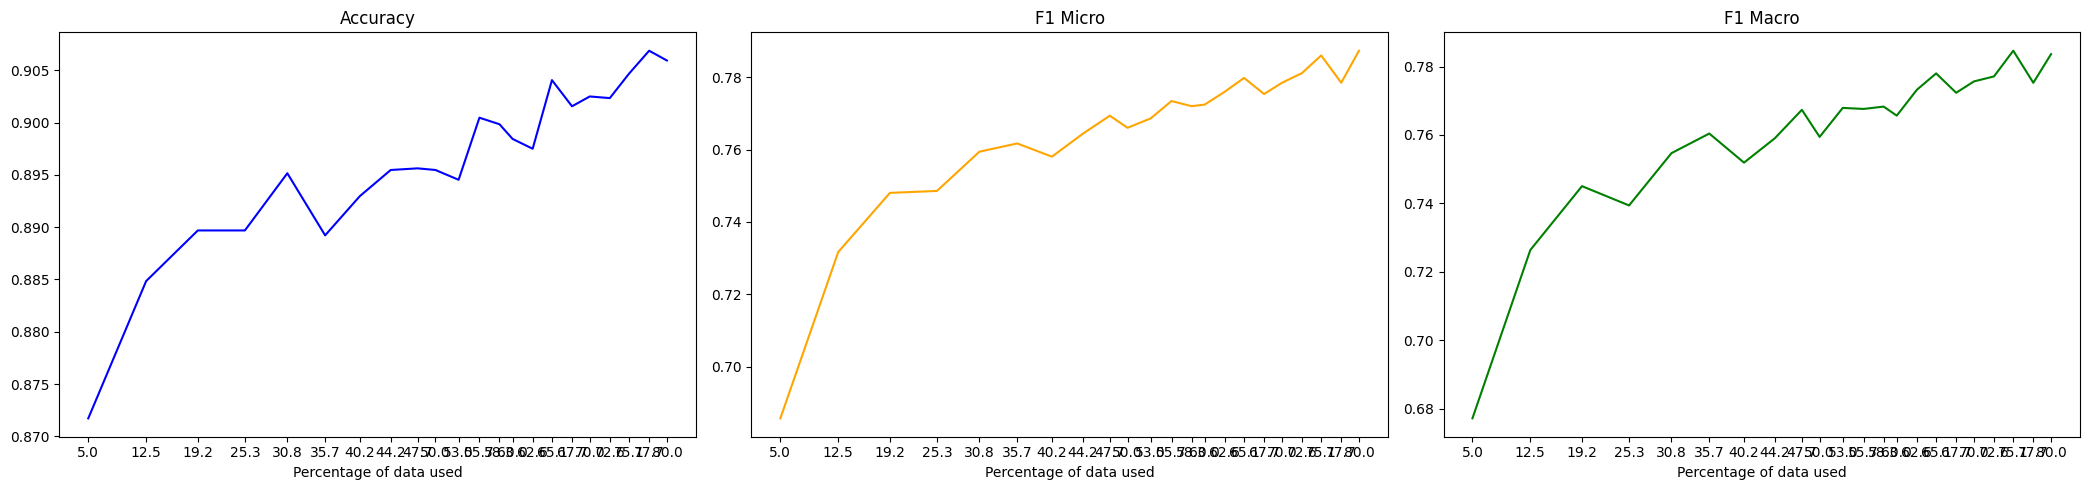

In [21]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6187, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4493, Accuracy: 0.7884, F1 Micro: 0.016, F1 Macro: 0.0144
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4203, Accuracy: 0.8111, F1 Micro: 0.2051, F1 Macro: 0.1483
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3885, Accuracy: 0.8291, F1 Micro: 0.3587, F1 Macro: 0.2765
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3558, Accuracy: 0.8389, F1 Micro: 0.4418, F1 Macro: 0.3567
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2968, Accuracy: 0.855, F1 Micro: 0.5455, F1 Macro: 0.48
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2508, Accuracy: 0.8719, F1 Micro: 0.6664, F1 Macro: 0.6505
Epoch 8/10, Train Loss: 0.2154, Accuracy: 0.8605, F1 Micro: 0.5802, F1 Macro: 0.5478
Epoch 9/10, Train Loss: 0.1636, Accuracy: 0.867, F1 Micro: 0.6343, F1 Macro: 0.6221
Higher F1 achie

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5288, Accuracy: 0.8213, F1 Micro: 0.2947, F1 Macro: 0.2137
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3869, Accuracy: 0.837, F1 Micro: 0.4328, F1 Macro: 0.3289
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.284, Accuracy: 0.8684, F1 Micro: 0.6693, F1 Macro: 0.6519
Epoch 4/10, Train Loss: 0.2399, Accuracy: 0.8706, F1 Micro: 0.648, F1 Macro: 0.6371
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1982, Accuracy: 0.8839, F1 Micro: 0.7231, F1 Macro: 0.7138
Epoch 6/10, Train Loss: 0.1608, Accuracy: 0.8828, F1 Micro: 0.7133, F1 Macro: 0.6975
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1213, Accuracy: 0.8798, F1 Micro: 0.7299, F1 Macro: 0.7246
Epoch 8/10, Train Loss: 0.1044, Accuracy: 0.8856, F1 Micro: 0.7265, F1 Macro: 0.7157
Epoch 9/10, Train Loss: 0.088, Accuracy: 0.8836, F1 Micro: 0.7173, F1 Macro: 0.7056
Epoch 10/10, Train Loss: 0.0714, Accuracy: 0.8839, F1 Micro: 0.7057, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5013, Accuracy: 0.8355, F1 Micro: 0.4166, F1 Macro: 0.2887
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3086, Accuracy: 0.8705, F1 Micro: 0.6637, F1 Macro: 0.6493
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2373, Accuracy: 0.882, F1 Micro: 0.7203, F1 Macro: 0.7104
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1966, Accuracy: 0.8853, F1 Micro: 0.7415, F1 Macro: 0.7369
Epoch 5/10, Train Loss: 0.1695, Accuracy: 0.8833, F1 Micro: 0.7018, F1 Macro: 0.6893
Epoch 6/10, Train Loss: 0.1217, Accuracy: 0.8822, F1 Micro: 0.7084, F1 Macro: 0.6885
Epoch 7/10, Train Loss: 0.0966, Accuracy: 0.8845, F1 Micro: 0.7096, F1 Macro: 0.6943
Epoch 8/10, Train Loss: 0.0754, Accuracy: 0.8873, F1 Micro: 0.7348, F1 Macro: 0.7296
Epoch 9/10, Train Loss: 0.0595, Accuracy: 0.8859, F1 Micro: 0.7316, F1 Macro: 0.7247
Epoch 10/10, Train Loss: 0.0492, Accuracy: 0.8825, F1 Micro: 0.7301, F1 Macro: 0.7197

 Iteration 1496: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4693, Accuracy: 0.847, F1 Micro: 0.5349, F1 Macro: 0.4496
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2877, Accuracy: 0.8691, F1 Micro: 0.636, F1 Macro: 0.6127
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.223, Accuracy: 0.8858, F1 Micro: 0.7224, F1 Macro: 0.7103
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1875, Accuracy: 0.89, F1 Micro: 0.753, F1 Macro: 0.7439
Epoch 5/10, Train Loss: 0.1523, Accuracy: 0.8867, F1 Micro: 0.741, F1 Macro: 0.7368
Epoch 6/10, Train Loss: 0.1187, Accuracy: 0.89, F1 Micro: 0.7412, F1 Macro: 0.73
Epoch 7/10, Train Loss: 0.0932, Accuracy: 0.8883, F1 Micro: 0.7345, F1 Macro: 0.7222
Epoch 8/10, Train Loss: 0.071, Accuracy: 0.8895, F1 Micro: 0.7456, F1 Macro: 0.7377
Epoch 9/10, Train Loss: 0.0618, Accuracy: 0.888, F1 Micro: 0.7384, F1 Macro: 0.731
Epoch 10/10, Train Loss: 0.0442, Accuracy: 0.8872, F1 Micro: 0.7401, F1 Macro: 0.7332

 Iteration 1969: Accuracy: 0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4495, Accuracy: 0.8602, F1 Micro: 0.5776, F1 Macro: 0.5337
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2722, Accuracy: 0.8783, F1 Micro: 0.6917, F1 Macro: 0.684
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2164, Accuracy: 0.8875, F1 Micro: 0.7458, F1 Macro: 0.7445
Epoch 4/10, Train Loss: 0.1817, Accuracy: 0.8925, F1 Micro: 0.7417, F1 Macro: 0.7289
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1435, Accuracy: 0.8945, F1 Micro: 0.7599, F1 Macro: 0.7535
Epoch 6/10, Train Loss: 0.1062, Accuracy: 0.8877, F1 Micro: 0.7402, F1 Macro: 0.7321
Epoch 7/10, Train Loss: 0.0814, Accuracy: 0.8966, F1 Micro: 0.7394, F1 Macro: 0.7315
Epoch 8/10, Train Loss: 0.0623, Accuracy: 0.8919, F1 Micro: 0.7504, F1 Macro: 0.7442
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.8916, F1 Micro: 0.7482, F1 Macro: 0.7393
Epoch 10/10, Train Loss: 0.0395, Accuracy: 0.893, F1 Micro: 0.7453, F1 Macro: 0.7297

 Iteration 2394: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4197, Accuracy: 0.8698, F1 Micro: 0.676, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.265, Accuracy: 0.8913, F1 Micro: 0.7493, F1 Macro: 0.748
Epoch 3/10, Train Loss: 0.2099, Accuracy: 0.8919, F1 Micro: 0.7478, F1 Macro: 0.7414
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.8975, F1 Micro: 0.7583, F1 Macro: 0.7484
Epoch 5/10, Train Loss: 0.134, Accuracy: 0.8992, F1 Micro: 0.7452, F1 Macro: 0.7387
Epoch 6/10, Train Loss: 0.1062, Accuracy: 0.8947, F1 Micro: 0.7439, F1 Macro: 0.7281
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.8966, F1 Micro: 0.7591, F1 Macro: 0.7525
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.8945, F1 Micro: 0.7624, F1 Macro: 0.7585
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.8934, F1 Micro: 0.7564, F1 Macro: 0.7534
Epoch 10/10, Train Loss: 0.0409, Accuracy: 0.8945, F1 Micro: 0.7571, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4291, Accuracy: 0.8669, F1 Micro: 0.6227, F1 Macro: 0.6082
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2603, Accuracy: 0.8856, F1 Micro: 0.7219, F1 Macro: 0.7151
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2093, Accuracy: 0.8838, F1 Micro: 0.7564, F1 Macro: 0.7557
Epoch 4/10, Train Loss: 0.1772, Accuracy: 0.893, F1 Micro: 0.7501, F1 Macro: 0.7372
Epoch 5/10, Train Loss: 0.1326, Accuracy: 0.8923, F1 Micro: 0.7549, F1 Macro: 0.7484
Epoch 6/10, Train Loss: 0.1107, Accuracy: 0.8961, F1 Micro: 0.7368, F1 Macro: 0.7284
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.895, F1 Micro: 0.7567, F1 Macro: 0.7509
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.061, Accuracy: 0.8927, F1 Micro: 0.7587, F1 Macro: 0.7497
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.8941, F1 Micro: 0.7485, F1 Macro: 0.7376
Epoch 10/10, Train Loss: 0.0375, Accuracy: 0.8908, F1 Micro: 0.7487, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.411, Accuracy: 0.8763, F1 Micro: 0.7045, F1 Macro: 0.7001
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2572, Accuracy: 0.8891, F1 Micro: 0.7286, F1 Macro: 0.7235
Epoch 3/10, Train Loss: 0.1977, Accuracy: 0.8898, F1 Micro: 0.7093, F1 Macro: 0.6967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1689, Accuracy: 0.8942, F1 Micro: 0.7566, F1 Macro: 0.7491
Epoch 5/10, Train Loss: 0.1335, Accuracy: 0.8955, F1 Micro: 0.7532, F1 Macro: 0.7479
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.8919, F1 Micro: 0.7258, F1 Macro: 0.7195
Epoch 7/10, Train Loss: 0.0687, Accuracy: 0.8914, F1 Micro: 0.7543, F1 Macro: 0.7494
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.8958, F1 Micro: 0.748, F1 Macro: 0.7408
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0441, Accuracy: 0.8931, F1 Micro: 0.7595, F1 Macro: 0.7591
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.8917, F1 Micro: 0.7624, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4093, Accuracy: 0.875, F1 Micro: 0.7057, F1 Macro: 0.6991
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2525, Accuracy: 0.8908, F1 Micro: 0.7351, F1 Macro: 0.7264
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2004, Accuracy: 0.897, F1 Micro: 0.7501, F1 Macro: 0.7414
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1689, Accuracy: 0.8975, F1 Micro: 0.7662, F1 Macro: 0.7619
Epoch 5/10, Train Loss: 0.1355, Accuracy: 0.8963, F1 Micro: 0.7442, F1 Macro: 0.7287
Epoch 6/10, Train Loss: 0.1025, Accuracy: 0.8964, F1 Micro: 0.7427, F1 Macro: 0.7297
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.8933, F1 Micro: 0.7495, F1 Macro: 0.7422
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.8933, F1 Micro: 0.7584, F1 Macro: 0.7517
Epoch 9/10, Train Loss: 0.0455, Accuracy: 0.897, F1 Micro: 0.7546, F1 Macro: 0.7447
Epoch 10/10, Train Loss: 0.0391, Accuracy: 0.8992, F1 Micro: 0.7591, F1 Macro: 0.755

 Iteration 3711: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3976, Accuracy: 0.8683, F1 Micro: 0.6221, F1 Macro: 0.604
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2382, Accuracy: 0.895, F1 Micro: 0.7365, F1 Macro: 0.7269
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2012, Accuracy: 0.8966, F1 Micro: 0.7685, F1 Macro: 0.7666
Epoch 4/10, Train Loss: 0.1597, Accuracy: 0.8992, F1 Micro: 0.7572, F1 Macro: 0.7474
Epoch 5/10, Train Loss: 0.126, Accuracy: 0.8973, F1 Micro: 0.7524, F1 Macro: 0.7451
Epoch 6/10, Train Loss: 0.0946, Accuracy: 0.8959, F1 Micro: 0.7507, F1 Macro: 0.7411
Epoch 7/10, Train Loss: 0.0758, Accuracy: 0.8969, F1 Micro: 0.7561, F1 Macro: 0.7488
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.8948, F1 Micro: 0.7604, F1 Macro: 0.7563
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.8967, F1 Micro: 0.7507, F1 Macro: 0.745
Epoch 10/10, Train Loss: 0.0352, Accuracy: 0.8886, F1 Micro: 0.7542, F1 Macro: 0.7514

 Iteration 3886: Accuracy: 0.8966, F1 Micro: 0.7685, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3987, Accuracy: 0.8798, F1 Micro: 0.7027, F1 Macro: 0.6992
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2461, Accuracy: 0.8931, F1 Micro: 0.7509, F1 Macro: 0.7448
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2094, Accuracy: 0.8956, F1 Micro: 0.7641, F1 Macro: 0.7591
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1799, Accuracy: 0.8931, F1 Micro: 0.7658, F1 Macro: 0.7613
Epoch 5/10, Train Loss: 0.1317, Accuracy: 0.8981, F1 Micro: 0.7583, F1 Macro: 0.747
Epoch 6/10, Train Loss: 0.0984, Accuracy: 0.898, F1 Micro: 0.7495, F1 Macro: 0.7378
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.8956, F1 Micro: 0.7567, F1 Macro: 0.7526
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.8941, F1 Micro: 0.7476, F1 Macro: 0.7418
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.8956, F1 Micro: 0.7515, F1 Macro: 0.7446
Epoch 10/10, Train Loss: 0.034, Accuracy: 0.8972, F1 Micro: 0.7606, F1 Macro: 0.7582

 Iteration 4120: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3964, Accuracy: 0.8797, F1 Micro: 0.7311, F1 Macro: 0.7272
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2479, Accuracy: 0.8952, F1 Micro: 0.742, F1 Macro: 0.7333
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2007, Accuracy: 0.9002, F1 Micro: 0.7487, F1 Macro: 0.7366
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1612, Accuracy: 0.8994, F1 Micro: 0.7695, F1 Macro: 0.7605
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1282, Accuracy: 0.9003, F1 Micro: 0.77, F1 Macro: 0.759
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.8977, F1 Micro: 0.775, F1 Macro: 0.7733
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.8997, F1 Micro: 0.7706, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0549, Accuracy: 0.902, F1 Micro: 0.7804, F1 Macro: 0.7789
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.8973, F1 Micro: 0.7654, F1 Macro: 0.7616
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3903, Accuracy: 0.8814, F1 Micro: 0.7043, F1 Macro: 0.6992
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2427, Accuracy: 0.8916, F1 Micro: 0.7146, F1 Macro: 0.6999
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2019, Accuracy: 0.897, F1 Micro: 0.7585, F1 Macro: 0.7366
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1604, Accuracy: 0.9019, F1 Micro: 0.7625, F1 Macro: 0.7528
Epoch 5/10, Train Loss: 0.1269, Accuracy: 0.8967, F1 Micro: 0.7334, F1 Macro: 0.7212
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0931, Accuracy: 0.8972, F1 Micro: 0.7706, F1 Macro: 0.7676
Epoch 7/10, Train Loss: 0.0712, Accuracy: 0.8988, F1 Micro: 0.7667, F1 Macro: 0.7657
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.898, F1 Micro: 0.7688, F1 Macro: 0.765
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.8972, F1 Micro: 0.7658, F1 Macro: 0.7643
Epoch 10/10, Train Loss: 0.0322, Accuracy: 0.8964, F1 Micro: 0.7646, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3917, Accuracy: 0.8809, F1 Micro: 0.7078, F1 Macro: 0.7061
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2532, Accuracy: 0.8973, F1 Micro: 0.7578, F1 Macro: 0.7524
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2046, Accuracy: 0.9009, F1 Micro: 0.7679, F1 Macro: 0.7602
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.9014, F1 Micro: 0.7755, F1 Macro: 0.7705
Epoch 5/10, Train Loss: 0.1233, Accuracy: 0.8981, F1 Micro: 0.758, F1 Macro: 0.7536
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.9003, F1 Micro: 0.763, F1 Macro: 0.7571
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.9003, F1 Micro: 0.7591, F1 Macro: 0.75
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.9002, F1 Micro: 0.7611, F1 Macro: 0.7565
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.8997, F1 Micro: 0.765, F1 Macro: 0.7583
Epoch 10/10, Train Loss: 0.0345, Accuracy: 0.9041, F1 Micro: 0.7753, F1 Macro: 0.7732

 Iteration 4663: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3834, Accuracy: 0.8839, F1 Micro: 0.7212, F1 Macro: 0.7205
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2485, Accuracy: 0.8941, F1 Micro: 0.7453, F1 Macro: 0.7272
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1994, Accuracy: 0.902, F1 Micro: 0.767, F1 Macro: 0.7573
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1642, Accuracy: 0.9014, F1 Micro: 0.7713, F1 Macro: 0.7694
Epoch 5/10, Train Loss: 0.1266, Accuracy: 0.8977, F1 Micro: 0.7707, F1 Macro: 0.7682
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9002, F1 Micro: 0.7586, F1 Macro: 0.7516
Epoch 7/10, Train Loss: 0.0684, Accuracy: 0.8998, F1 Micro: 0.7622, F1 Macro: 0.7546
Epoch 8/10, Train Loss: 0.0512, Accuracy: 0.8964, F1 Micro: 0.7602, F1 Macro: 0.7562
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.8948, F1 Micro: 0.7715, F1 Macro: 0.7734
Epoch 10/10, Train Loss: 0.0353, Accuracy: 0.8948, F1 Micro: 0.7623, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3913, Accuracy: 0.8792, F1 Micro: 0.6745, F1 Macro: 0.6733
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2405, Accuracy: 0.8969, F1 Micro: 0.7686, F1 Macro: 0.7687
Epoch 3/10, Train Loss: 0.2054, Accuracy: 0.8948, F1 Micro: 0.7162, F1 Macro: 0.7034
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1593, Accuracy: 0.9061, F1 Micro: 0.773, F1 Macro: 0.7643
Epoch 5/10, Train Loss: 0.1314, Accuracy: 0.8986, F1 Micro: 0.7703, F1 Macro: 0.7692
Epoch 6/10, Train Loss: 0.0916, Accuracy: 0.9047, F1 Micro: 0.771, F1 Macro: 0.7662
Epoch 7/10, Train Loss: 0.0656, Accuracy: 0.8983, F1 Micro: 0.7704, F1 Macro: 0.7682
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.9013, F1 Micro: 0.7727, F1 Macro: 0.7734
Epoch 9/10, Train Loss: 0.0436, Accuracy: 0.9013, F1 Micro: 0.7664, F1 Macro: 0.7628
Epoch 10/10, Train Loss: 0.0298, Accuracy: 0.8977, F1 Micro: 0.7701, F1 Macro: 0.7702

 Iteration 5063: Accuracy: 0.9061, F1 Micro: 0.773,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3846, Accuracy: 0.8848, F1 Micro: 0.7111, F1 Macro: 0.6983
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.246, Accuracy: 0.9009, F1 Micro: 0.7652, F1 Macro: 0.7604
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1985, Accuracy: 0.8959, F1 Micro: 0.7761, F1 Macro: 0.7742
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.9034, F1 Micro: 0.7582, F1 Macro: 0.7535
Epoch 5/10, Train Loss: 0.1301, Accuracy: 0.8981, F1 Micro: 0.7615, F1 Macro: 0.7534
Epoch 6/10, Train Loss: 0.0921, Accuracy: 0.9042, F1 Micro: 0.7627, F1 Macro: 0.7542
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.9027, F1 Micro: 0.7669, F1 Macro: 0.7557
Epoch 8/10, Train Loss: 0.0538, Accuracy: 0.9025, F1 Micro: 0.7682, F1 Macro: 0.7625
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.9023, F1 Micro: 0.7639, F1 Macro: 0.7573
Epoch 10/10, Train Loss: 0.0332, Accuracy: 0.8998, F1 Micro: 0.7698, F1 Macro: 0.768

 Iteration 5263: Accuracy: 0.8959, F1 Micro: 0.7761,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3736, Accuracy: 0.8867, F1 Micro: 0.7452, F1 Macro: 0.7378
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.244, Accuracy: 0.8975, F1 Micro: 0.7743, F1 Macro: 0.7708
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1961, Accuracy: 0.9059, F1 Micro: 0.7812, F1 Macro: 0.773
Epoch 4/10, Train Loss: 0.1536, Accuracy: 0.9042, F1 Micro: 0.7679, F1 Macro: 0.7554
Epoch 5/10, Train Loss: 0.1162, Accuracy: 0.8994, F1 Micro: 0.772, F1 Macro: 0.7728
Epoch 6/10, Train Loss: 0.0897, Accuracy: 0.9008, F1 Micro: 0.773, F1 Macro: 0.7699
Epoch 7/10, Train Loss: 0.0701, Accuracy: 0.9008, F1 Micro: 0.7633, F1 Macro: 0.7612
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.8991, F1 Micro: 0.7637, F1 Macro: 0.7587
Epoch 9/10, Train Loss: 0.0416, Accuracy: 0.8992, F1 Micro: 0.7774, F1 Macro: 0.777
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.8991, F1 Micro: 0.7762, F1 Macro: 0.7732

 Iteration 5441: Accuracy: 0.9059, F1 Micro: 0.7812, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3762, Accuracy: 0.8891, F1 Micro: 0.7304, F1 Macro: 0.7136
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2418, Accuracy: 0.8991, F1 Micro: 0.7668, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2035, Accuracy: 0.9016, F1 Micro: 0.7788, F1 Macro: 0.7775
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1536, Accuracy: 0.9045, F1 Micro: 0.7816, F1 Macro: 0.7785
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.905, F1 Micro: 0.7711, F1 Macro: 0.7668
Epoch 6/10, Train Loss: 0.0904, Accuracy: 0.9011, F1 Micro: 0.7592, F1 Macro: 0.7524
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9028, F1 Micro: 0.7635, F1 Macro: 0.7562
Epoch 8/10, Train Loss: 0.0453, Accuracy: 0.9031, F1 Micro: 0.763, F1 Macro: 0.7533
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9047, F1 Micro: 0.7815, F1 Macro: 0.7801
Epoch 10/10, Train Loss: 0.0284, Accuracy: 0.8963, F1 Micro: 0.7662, F1 Macro: 0.7646

 Iteration 5641: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3709, Accuracy: 0.8906, F1 Micro: 0.738, F1 Macro: 0.7329
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2452, Accuracy: 0.8998, F1 Micro: 0.7611, F1 Macro: 0.756
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1971, Accuracy: 0.9066, F1 Micro: 0.784, F1 Macro: 0.7814
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1606, Accuracy: 0.9038, F1 Micro: 0.7899, F1 Macro: 0.7912
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9062, F1 Micro: 0.777, F1 Macro: 0.7711
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9044, F1 Micro: 0.7869, F1 Macro: 0.7903
Epoch 7/10, Train Loss: 0.0669, Accuracy: 0.9031, F1 Micro: 0.7795, F1 Macro: 0.7783
Epoch 8/10, Train Loss: 0.0472, Accuracy: 0.9044, F1 Micro: 0.7771, F1 Macro: 0.7733
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.9009, F1 Micro: 0.7814, F1 Macro: 0.7807
Epoch 10/10, Train Loss: 0.0307, Accuracy: 0.9013, F1 Micro: 0.7698, F1 Macro: 0.7665

 Iteration 5841: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3701, Accuracy: 0.8878, F1 Micro: 0.7204, F1 Macro: 0.7175
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.238, Accuracy: 0.9016, F1 Micro: 0.7468, F1 Macro: 0.7399
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1974, Accuracy: 0.9053, F1 Micro: 0.7825, F1 Macro: 0.7732
Epoch 4/10, Train Loss: 0.1588, Accuracy: 0.9011, F1 Micro: 0.7737, F1 Macro: 0.7732
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1265, Accuracy: 0.9045, F1 Micro: 0.7854, F1 Macro: 0.7873
Epoch 6/10, Train Loss: 0.0937, Accuracy: 0.903, F1 Micro: 0.7788, F1 Macro: 0.7779
Epoch 7/10, Train Loss: 0.0633, Accuracy: 0.9011, F1 Micro: 0.7798, F1 Macro: 0.7795
Epoch 8/10, Train Loss: 0.0478, Accuracy: 0.9045, F1 Micro: 0.7785, F1 Macro: 0.7765
Epoch 9/10, Train Loss: 0.0382, Accuracy: 0.903, F1 Micro: 0.7728, F1 Macro: 0.7663
Epoch 10/10, Train Loss: 0.0321, Accuracy: 0.9078, F1 Micro: 0.7807, F1 Macro: 0.7764

 Iteration 6041: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3597, Accuracy: 0.8908, F1 Micro: 0.7319, F1 Macro: 0.731
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2346, Accuracy: 0.9005, F1 Micro: 0.774, F1 Macro: 0.77
Epoch 3/10, Train Loss: 0.1921, Accuracy: 0.9031, F1 Micro: 0.7707, F1 Macro: 0.7634
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1569, Accuracy: 0.8992, F1 Micro: 0.7845, F1 Macro: 0.7849
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1233, Accuracy: 0.907, F1 Micro: 0.7873, F1 Macro: 0.7838
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.9083, F1 Micro: 0.7863, F1 Macro: 0.7799
Epoch 7/10, Train Loss: 0.0651, Accuracy: 0.9053, F1 Micro: 0.7825, F1 Macro: 0.777
Epoch 8/10, Train Loss: 0.0444, Accuracy: 0.9013, F1 Micro: 0.7715, F1 Macro: 0.768
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.9059, F1 Micro: 0.7706, F1 Macro: 0.7614
Epoch 10/10, Train Loss: 0.0288, Accuracy: 0.9041, F1 Micro: 0.7775, F1 Macro: 0.7689

 Iteration 6218: Accura

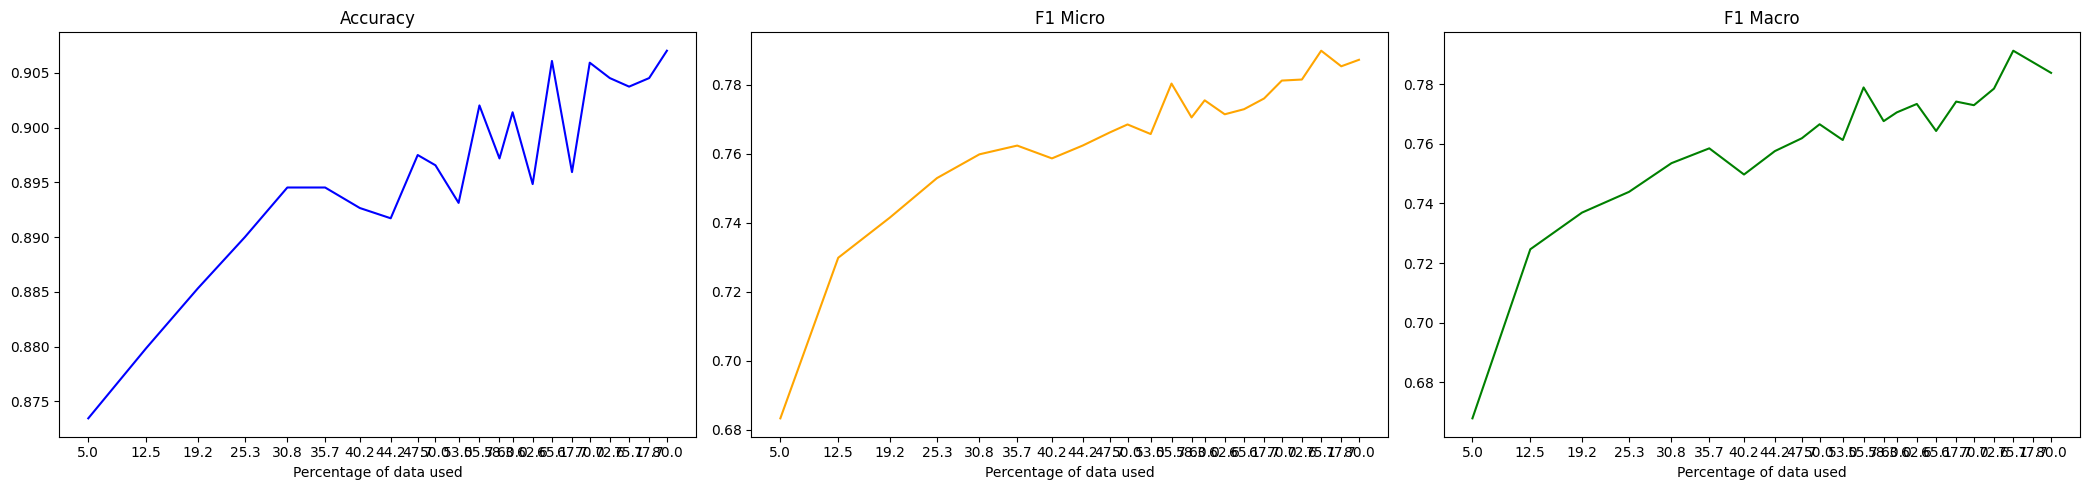

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5896, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4953, Accuracy: 0.79, F1 Micro: 0.0303, F1 Macro: 0.0269
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4288, Accuracy: 0.8306, F1 Micro: 0.3593, F1 Macro: 0.2395
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3915, Accuracy: 0.835, F1 Micro: 0.4413, F1 Macro: 0.3366
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3345, Accuracy: 0.8445, F1 Micro: 0.4826, F1 Macro: 0.381
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2887, Accuracy: 0.8612, F1 Micro: 0.6162, F1 Macro: 0.5481
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2536, Accuracy: 0.8698, F1 Micro: 0.6548, F1 Macro: 0.6311
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2078, Accuracy: 0.8711, F1 Micro: 0.6642, F1 Macro: 0.6388
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1918, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5272, Accuracy: 0.8211, F1 Micro: 0.2857, F1 Macro: 0.204
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3675, Accuracy: 0.845, F1 Micro: 0.5089, F1 Macro: 0.4167
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2971, Accuracy: 0.8686, F1 Micro: 0.6332, F1 Macro: 0.6087
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2388, Accuracy: 0.8755, F1 Micro: 0.6933, F1 Macro: 0.6851
Epoch 5/10, Train Loss: 0.1888, Accuracy: 0.877, F1 Micro: 0.6664, F1 Macro: 0.6496
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1551, Accuracy: 0.8798, F1 Micro: 0.7176, F1 Macro: 0.7089
Epoch 7/10, Train Loss: 0.1284, Accuracy: 0.8834, F1 Micro: 0.7135, F1 Macro: 0.697
Epoch 8/10, Train Loss: 0.1026, Accuracy: 0.8791, F1 Micro: 0.7125, F1 Macro: 0.6957
Epoch 9/10, Train Loss: 0.0869, Accuracy: 0.8834, F1 Micro: 0.7148, F1 Macro: 0.6952
Epoch 10/10, Train Loss: 0.072, Accuracy: 0.8828, F1 Micro: 0.7059, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.482, Accuracy: 0.8386, F1 Micro: 0.4973, F1 Macro: 0.3633
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3349, Accuracy: 0.8694, F1 Micro: 0.6777, F1 Macro: 0.6646
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2489, Accuracy: 0.8805, F1 Micro: 0.7247, F1 Macro: 0.7198
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2021, Accuracy: 0.8875, F1 Micro: 0.7262, F1 Macro: 0.7156
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1718, Accuracy: 0.8847, F1 Micro: 0.7283, F1 Macro: 0.7168
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1292, Accuracy: 0.8823, F1 Micro: 0.7431, F1 Macro: 0.7427
Epoch 7/10, Train Loss: 0.1083, Accuracy: 0.8844, F1 Micro: 0.7396, F1 Macro: 0.7319
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0924, Accuracy: 0.8853, F1 Micro: 0.7437, F1 Macro: 0.7407
Epoch 9/10, Train Loss: 0.0644, Accuracy: 0.8873, F1 Micro: 0.7362, F1 Macro: 0.73
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4715, Accuracy: 0.8452, F1 Micro: 0.482, F1 Macro: 0.3923
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3034, Accuracy: 0.8752, F1 Micro: 0.7011, F1 Macro: 0.681
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2331, Accuracy: 0.8816, F1 Micro: 0.739, F1 Macro: 0.7321
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.207, Accuracy: 0.8867, F1 Micro: 0.7457, F1 Macro: 0.7435
Epoch 5/10, Train Loss: 0.1674, Accuracy: 0.8922, F1 Micro: 0.7448, F1 Macro: 0.7363
Epoch 6/10, Train Loss: 0.1276, Accuracy: 0.8886, F1 Micro: 0.7346, F1 Macro: 0.7217
Epoch 7/10, Train Loss: 0.0983, Accuracy: 0.885, F1 Micro: 0.7282, F1 Macro: 0.7107
Epoch 8/10, Train Loss: 0.0693, Accuracy: 0.89, F1 Micro: 0.7325, F1 Macro: 0.7201
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.058, Accuracy: 0.888, F1 Micro: 0.748, F1 Macro: 0.7429
Epoch 10/10, Train Loss: 0.0466, Accuracy: 0.8889, F1 Micro: 0.7442, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4454, Accuracy: 0.8591, F1 Micro: 0.6051, F1 Macro: 0.5107
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2774, Accuracy: 0.8855, F1 Micro: 0.7296, F1 Macro: 0.7272
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2211, Accuracy: 0.892, F1 Micro: 0.7549, F1 Macro: 0.7466
Epoch 4/10, Train Loss: 0.182, Accuracy: 0.8927, F1 Micro: 0.7305, F1 Macro: 0.7124
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1389, Accuracy: 0.8909, F1 Micro: 0.757, F1 Macro: 0.751
Epoch 6/10, Train Loss: 0.1099, Accuracy: 0.8861, F1 Micro: 0.7528, F1 Macro: 0.7507
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.885, F1 Micro: 0.7538, F1 Macro: 0.751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0643, Accuracy: 0.893, F1 Micro: 0.7624, F1 Macro: 0.7585
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.8916, F1 Micro: 0.7565, F1 Macro: 0.754
Epoch 10/10, Train Loss: 0.04, Accuracy: 0.8927, F1 Micro: 0.754, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4274, Accuracy: 0.8683, F1 Micro: 0.6374, F1 Macro: 0.6196
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2686, Accuracy: 0.8875, F1 Micro: 0.7303, F1 Macro: 0.7247
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2121, Accuracy: 0.8906, F1 Micro: 0.7516, F1 Macro: 0.7501
Epoch 4/10, Train Loss: 0.1762, Accuracy: 0.8947, F1 Micro: 0.7455, F1 Macro: 0.7288
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1316, Accuracy: 0.8947, F1 Micro: 0.7622, F1 Macro: 0.7558
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.107, Accuracy: 0.8892, F1 Micro: 0.7631, F1 Macro: 0.7642
Epoch 7/10, Train Loss: 0.0819, Accuracy: 0.8906, F1 Micro: 0.7613, F1 Macro: 0.7599
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.8922, F1 Micro: 0.7553, F1 Macro: 0.7483
Epoch 9/10, Train Loss: 0.0427, Accuracy: 0.8922, F1 Micro: 0.7534, F1 Macro: 0.7465
Epoch 10/10, Train Loss: 0.039, Accuracy: 0.8925, F1 Micro: 0.7559, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4206, Accuracy: 0.8722, F1 Micro: 0.6696, F1 Macro: 0.6645
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2698, Accuracy: 0.8884, F1 Micro: 0.7379, F1 Macro: 0.7335
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.21, Accuracy: 0.8928, F1 Micro: 0.7504, F1 Macro: 0.74
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1738, Accuracy: 0.8969, F1 Micro: 0.7656, F1 Macro: 0.7604
Epoch 5/10, Train Loss: 0.1369, Accuracy: 0.8911, F1 Micro: 0.7571, F1 Macro: 0.7473
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.8967, F1 Micro: 0.7536, F1 Macro: 0.7451
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.8886, F1 Micro: 0.7594, F1 Macro: 0.7568
Epoch 8/10, Train Loss: 0.0555, Accuracy: 0.8936, F1 Micro: 0.7549, F1 Macro: 0.7497
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.8925, F1 Micro: 0.7476, F1 Macro: 0.7406
Epoch 10/10, Train Loss: 0.0416, Accuracy: 0.8914, F1 Micro: 0.7578, F1 Macro: 0.7539

 Iteration 3122: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4148, Accuracy: 0.8705, F1 Micro: 0.7094, F1 Macro: 0.7076
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2597, Accuracy: 0.8903, F1 Micro: 0.7457, F1 Macro: 0.7409
Epoch 3/10, Train Loss: 0.2104, Accuracy: 0.8931, F1 Micro: 0.7359, F1 Macro: 0.7303
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1773, Accuracy: 0.8936, F1 Micro: 0.7644, F1 Macro: 0.7632
Epoch 5/10, Train Loss: 0.1357, Accuracy: 0.8906, F1 Micro: 0.759, F1 Macro: 0.76
Epoch 6/10, Train Loss: 0.0942, Accuracy: 0.8933, F1 Micro: 0.7591, F1 Macro: 0.7561
Epoch 7/10, Train Loss: 0.0772, Accuracy: 0.8938, F1 Micro: 0.7614, F1 Macro: 0.7573
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0568, Accuracy: 0.8939, F1 Micro: 0.765, F1 Macro: 0.7629
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.046, Accuracy: 0.8964, F1 Micro: 0.7665, F1 Macro: 0.7617
Epoch 10/10, Train Loss: 0.0367, Accuracy: 0.8933, F1 Micro: 0.7641, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4119, Accuracy: 0.8747, F1 Micro: 0.6974, F1 Macro: 0.6819
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2568, Accuracy: 0.8922, F1 Micro: 0.736, F1 Macro: 0.7289
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2032, Accuracy: 0.8959, F1 Micro: 0.7526, F1 Macro: 0.7477
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1679, Accuracy: 0.8973, F1 Micro: 0.7607, F1 Macro: 0.7564
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.8973, F1 Micro: 0.7568, F1 Macro: 0.7474
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.8967, F1 Micro: 0.7531, F1 Macro: 0.7382
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.898, F1 Micro: 0.7588, F1 Macro: 0.7578
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.8967, F1 Micro: 0.7535, F1 Macro: 0.7418
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.8956, F1 Micro: 0.759, F1 Macro: 0.7532
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0354, Accuracy: 0.8988, F1 Micro: 0.7647, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3989, Accuracy: 0.8766, F1 Micro: 0.7266, F1 Macro: 0.7246
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2623, Accuracy: 0.8864, F1 Micro: 0.747, F1 Macro: 0.7411
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2011, Accuracy: 0.8967, F1 Micro: 0.7574, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1592, Accuracy: 0.8916, F1 Micro: 0.7646, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.8955, F1 Micro: 0.7713, F1 Macro: 0.7692
Epoch 6/10, Train Loss: 0.0897, Accuracy: 0.8989, F1 Micro: 0.7608, F1 Macro: 0.7554
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.8972, F1 Micro: 0.7586, F1 Macro: 0.7542
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.8923, F1 Micro: 0.7679, F1 Macro: 0.7676
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.9011, F1 Micro: 0.7663, F1 Macro: 0.7626
Epoch 10/10, Train Loss: 0.0364, Accuracy: 0.8948, F1 Micro: 0.7688, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3893, Accuracy: 0.8798, F1 Micro: 0.7217, F1 Macro: 0.7225
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.253, Accuracy: 0.8923, F1 Micro: 0.7443, F1 Macro: 0.7383
Epoch 3/10, Train Loss: 0.2077, Accuracy: 0.8956, F1 Micro: 0.7289, F1 Macro: 0.7081
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.8895, F1 Micro: 0.7636, F1 Macro: 0.7632
Epoch 5/10, Train Loss: 0.1274, Accuracy: 0.8898, F1 Micro: 0.763, F1 Macro: 0.7627
Epoch 6/10, Train Loss: 0.0922, Accuracy: 0.8973, F1 Micro: 0.76, F1 Macro: 0.7513
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0724, Accuracy: 0.9019, F1 Micro: 0.7657, F1 Macro: 0.7638
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0536, Accuracy: 0.9034, F1 Micro: 0.7733, F1 Macro: 0.7664
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.9017, F1 Micro: 0.7636, F1 Macro: 0.7552
Epoch 10/10, Train Loss: 0.0359, Accuracy: 0.9013, F1 Micro: 0.7692, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3974, Accuracy: 0.8798, F1 Micro: 0.718, F1 Macro: 0.7185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2521, Accuracy: 0.8936, F1 Micro: 0.7467, F1 Macro: 0.7387
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2045, Accuracy: 0.9044, F1 Micro: 0.7723, F1 Macro: 0.7683
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1702, Accuracy: 0.8991, F1 Micro: 0.7752, F1 Macro: 0.7738
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.898, F1 Micro: 0.7495, F1 Macro: 0.7438
Epoch 6/10, Train Loss: 0.0921, Accuracy: 0.8972, F1 Micro: 0.7725, F1 Macro: 0.77
Epoch 7/10, Train Loss: 0.0685, Accuracy: 0.8958, F1 Micro: 0.7731, F1 Macro: 0.7726
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9013, F1 Micro: 0.7644, F1 Macro: 0.7623
Epoch 9/10, Train Loss: 0.0444, Accuracy: 0.8944, F1 Micro: 0.7651, F1 Macro: 0.7649
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.8933, F1 Micro: 0.7642, F1 Macro: 0.7633

 Iteration 4330: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3914, Accuracy: 0.8819, F1 Micro: 0.7281, F1 Macro: 0.722
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2453, Accuracy: 0.8945, F1 Micro: 0.7432, F1 Macro: 0.7356
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2021, Accuracy: 0.9002, F1 Micro: 0.7584, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1582, Accuracy: 0.8972, F1 Micro: 0.768, F1 Macro: 0.7631
Epoch 5/10, Train Loss: 0.1165, Accuracy: 0.8997, F1 Micro: 0.7583, F1 Macro: 0.7472
Epoch 6/10, Train Loss: 0.0897, Accuracy: 0.8944, F1 Micro: 0.7651, F1 Macro: 0.7628
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0641, Accuracy: 0.8994, F1 Micro: 0.7683, F1 Macro: 0.7618
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0508, Accuracy: 0.9036, F1 Micro: 0.7695, F1 Macro: 0.765
Epoch 9/10, Train Loss: 0.0416, Accuracy: 0.8953, F1 Micro: 0.7646, F1 Macro: 0.7622
Epoch 10/10, Train Loss: 0.0341, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3812, Accuracy: 0.8838, F1 Micro: 0.7251, F1 Macro: 0.7099
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.248, Accuracy: 0.893, F1 Micro: 0.7441, F1 Macro: 0.739
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1978, Accuracy: 0.9022, F1 Micro: 0.764, F1 Macro: 0.7532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.161, Accuracy: 0.8952, F1 Micro: 0.7714, F1 Macro: 0.7703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.126, Accuracy: 0.9034, F1 Micro: 0.7748, F1 Macro: 0.7706
Epoch 6/10, Train Loss: 0.0846, Accuracy: 0.9011, F1 Micro: 0.7711, F1 Macro: 0.7672
Epoch 7/10, Train Loss: 0.0724, Accuracy: 0.9, F1 Micro: 0.7696, F1 Macro: 0.7656
Epoch 8/10, Train Loss: 0.0496, Accuracy: 0.9002, F1 Micro: 0.771, F1 Macro: 0.7691
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0375, Accuracy: 0.9052, F1 Micro: 0.7763, F1 Macro: 0.7732
Epoch 10/10, Train Loss: 0.0367, Accuracy: 0.90

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3798, Accuracy: 0.8819, F1 Micro: 0.7216, F1 Macro: 0.7048
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2457, Accuracy: 0.8938, F1 Micro: 0.7617, F1 Macro: 0.7585
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2016, Accuracy: 0.9014, F1 Micro: 0.7754, F1 Macro: 0.7708
Epoch 4/10, Train Loss: 0.1634, Accuracy: 0.8955, F1 Micro: 0.7738, F1 Macro: 0.7736
Epoch 5/10, Train Loss: 0.1229, Accuracy: 0.8948, F1 Micro: 0.7732, F1 Macro: 0.7703
Epoch 6/10, Train Loss: 0.0907, Accuracy: 0.8955, F1 Micro: 0.767, F1 Macro: 0.7643
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.9003, F1 Micro: 0.77, F1 Macro: 0.7673
Epoch 8/10, Train Loss: 0.0477, Accuracy: 0.9009, F1 Micro: 0.7723, F1 Macro: 0.7668
Epoch 9/10, Train Loss: 0.0403, Accuracy: 0.8969, F1 Micro: 0.7741, F1 Macro: 0.7702
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0296, Accuracy: 0.8992, F1 Micro: 0.7778, F1 Macro: 0.776

 Iteration 4863: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3768, Accuracy: 0.8834, F1 Micro: 0.7009, F1 Macro: 0.6918
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2361, Accuracy: 0.8984, F1 Micro: 0.7569, F1 Macro: 0.7455
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1973, Accuracy: 0.9016, F1 Micro: 0.7806, F1 Macro: 0.7783
Epoch 4/10, Train Loss: 0.1596, Accuracy: 0.9031, F1 Micro: 0.7662, F1 Macro: 0.7559
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.902, F1 Micro: 0.7742, F1 Macro: 0.7673
Epoch 6/10, Train Loss: 0.0921, Accuracy: 0.9019, F1 Micro: 0.7752, F1 Macro: 0.7711
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.063, Accuracy: 0.9052, F1 Micro: 0.7857, F1 Macro: 0.7826
Epoch 8/10, Train Loss: 0.0524, Accuracy: 0.8991, F1 Micro: 0.7664, F1 Macro: 0.7596
Epoch 9/10, Train Loss: 0.0375, Accuracy: 0.8983, F1 Micro: 0.7795, F1 Macro: 0.7776
Epoch 10/10, Train Loss: 0.0285, Accuracy: 0.9009, F1 Micro: 0.7714, F1 Macro: 0.764

 Iteration 5063: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3736, Accuracy: 0.8828, F1 Micro: 0.7401, F1 Macro: 0.7357
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2424, Accuracy: 0.8983, F1 Micro: 0.763, F1 Macro: 0.7559
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2009, Accuracy: 0.8967, F1 Micro: 0.7766, F1 Macro: 0.7713
Epoch 4/10, Train Loss: 0.1637, Accuracy: 0.8956, F1 Micro: 0.7739, F1 Macro: 0.773
Epoch 5/10, Train Loss: 0.126, Accuracy: 0.9022, F1 Micro: 0.7627, F1 Macro: 0.7606
Epoch 6/10, Train Loss: 0.0864, Accuracy: 0.8994, F1 Micro: 0.7737, F1 Macro: 0.7747
Epoch 7/10, Train Loss: 0.0671, Accuracy: 0.9008, F1 Micro: 0.7705, F1 Macro: 0.7679
Epoch 8/10, Train Loss: 0.0455, Accuracy: 0.8977, F1 Micro: 0.7698, F1 Macro: 0.7691
Epoch 9/10, Train Loss: 0.0395, Accuracy: 0.898, F1 Micro: 0.768, F1 Macro: 0.7652
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0282, Accuracy: 0.9028, F1 Micro: 0.7774, F1 Macro: 0.7744

 Iteration 5263: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3743, Accuracy: 0.8872, F1 Micro: 0.7188, F1 Macro: 0.6987
Epoch 2/10, Train Loss: 0.2458, Accuracy: 0.8888, F1 Micro: 0.6923, F1 Macro: 0.6629
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1964, Accuracy: 0.9002, F1 Micro: 0.7832, F1 Macro: 0.7806
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9066, F1 Micro: 0.7849, F1 Macro: 0.7808
Epoch 5/10, Train Loss: 0.121, Accuracy: 0.8922, F1 Micro: 0.773, F1 Macro: 0.7723
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.8981, F1 Micro: 0.7707, F1 Macro: 0.7643
Epoch 7/10, Train Loss: 0.0649, Accuracy: 0.9017, F1 Micro: 0.7737, F1 Macro: 0.7698
Epoch 8/10, Train Loss: 0.0489, Accuracy: 0.9038, F1 Micro: 0.7836, F1 Macro: 0.781
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.9033, F1 Micro: 0.7715, F1 Macro: 0.7674
Epoch 10/10, Train Loss: 0.0314, Accuracy: 0.902, F1 Micro: 0.7808, F1 Macro: 0.782

 Iteration 5441: Accuracy: 0.9066, F1 Micro: 0.7849, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3663, Accuracy: 0.8844, F1 Micro: 0.6957, F1 Macro: 0.6968
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2443, Accuracy: 0.9, F1 Micro: 0.7482, F1 Macro: 0.7378
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1964, Accuracy: 0.9044, F1 Micro: 0.7799, F1 Macro: 0.7745
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1613, Accuracy: 0.9048, F1 Micro: 0.783, F1 Macro: 0.7757
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.9067, F1 Micro: 0.7853, F1 Macro: 0.7753
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9044, F1 Micro: 0.7755, F1 Macro: 0.7712
Epoch 7/10, Train Loss: 0.062, Accuracy: 0.9023, F1 Micro: 0.778, F1 Macro: 0.7762
Epoch 8/10, Train Loss: 0.0462, Accuracy: 0.9062, F1 Micro: 0.7751, F1 Macro: 0.7729
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.9031, F1 Micro: 0.7737, F1 Macro: 0.7715
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.9039, F1 Micro: 0.7787, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.355, Accuracy: 0.8864, F1 Micro: 0.7089, F1 Macro: 0.6841
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2392, Accuracy: 0.9008, F1 Micro: 0.7443, F1 Macro: 0.7334
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1984, Accuracy: 0.9025, F1 Micro: 0.7668, F1 Macro: 0.754
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1541, Accuracy: 0.9028, F1 Micro: 0.7854, F1 Macro: 0.7846
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.903, F1 Micro: 0.7611, F1 Macro: 0.7472
Epoch 6/10, Train Loss: 0.086, Accuracy: 0.9041, F1 Micro: 0.7821, F1 Macro: 0.7784
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9027, F1 Micro: 0.7824, F1 Macro: 0.7788
Epoch 8/10, Train Loss: 0.0476, Accuracy: 0.9011, F1 Micro: 0.7677, F1 Macro: 0.7649
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.905, F1 Micro: 0.7746, F1 Macro: 0.7709
Epoch 10/10, Train Loss: 0.0305, Accuracy: 0.9064, F1 Micro: 0.7742, F1 Macro: 0.7716

 Iteration 5841: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3581, Accuracy: 0.8941, F1 Micro: 0.7463, F1 Macro: 0.7369
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2408, Accuracy: 0.9014, F1 Micro: 0.7762, F1 Macro: 0.7739
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1947, Accuracy: 0.9058, F1 Micro: 0.7821, F1 Macro: 0.7705
Epoch 4/10, Train Loss: 0.1567, Accuracy: 0.91, F1 Micro: 0.7795, F1 Macro: 0.7676
Epoch 5/10, Train Loss: 0.1187, Accuracy: 0.9056, F1 Micro: 0.7761, F1 Macro: 0.769
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.9056, F1 Micro: 0.7726, F1 Macro: 0.7669
Epoch 7/10, Train Loss: 0.0647, Accuracy: 0.9031, F1 Micro: 0.7617, F1 Macro: 0.7533
Epoch 8/10, Train Loss: 0.0498, Accuracy: 0.9069, F1 Micro: 0.7801, F1 Macro: 0.7755
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.9031, F1 Micro: 0.7792, F1 Macro: 0.7766
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0282, Accuracy: 0.9017, F1 Micro: 0.7839, F1 Macro: 0.7822

 Iteration 6041: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.355, Accuracy: 0.8878, F1 Micro: 0.7182, F1 Macro: 0.6994
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2376, Accuracy: 0.9011, F1 Micro: 0.7635, F1 Macro: 0.7605
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1835, Accuracy: 0.9025, F1 Micro: 0.7836, F1 Macro: 0.7785
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1499, Accuracy: 0.9055, F1 Micro: 0.7864, F1 Macro: 0.7837
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.903, F1 Micro: 0.777, F1 Macro: 0.7728
Epoch 6/10, Train Loss: 0.0828, Accuracy: 0.9003, F1 Micro: 0.7739, F1 Macro: 0.7746
Epoch 7/10, Train Loss: 0.0616, Accuracy: 0.9011, F1 Micro: 0.7783, F1 Macro: 0.7751
Epoch 8/10, Train Loss: 0.0504, Accuracy: 0.9036, F1 Micro: 0.7775, F1 Macro: 0.7741
Epoch 9/10, Train Loss: 0.0348, Accuracy: 0.9017, F1 Micro: 0.7683, F1 Macro: 0.7659
Epoch 10/10, Train Loss: 0.0292, Accuracy: 0.9036, F1 Micro: 0.7678, F1 Macro: 0.7592

 Iteration 6218: Ac

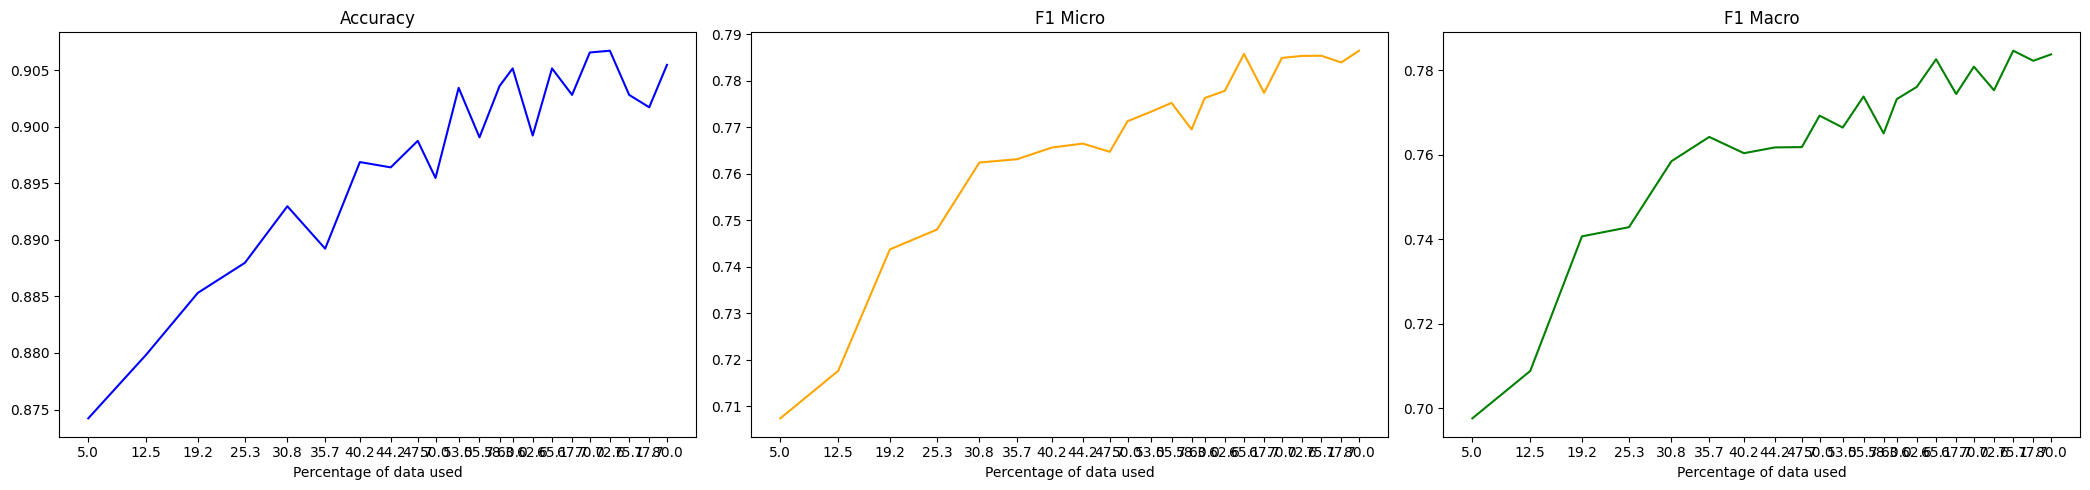

In [ ]:
active_learning(seeds[4], 4)